In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BertModel, BertTokenizer,
    AutoModel, AutoTokenizer,
    get_linear_schedule_with_warmup
)
from torchvision import models, transforms
from datasets import load_dataset
from PIL import Image
import numpy as np
from tqdm import tqdm
import argparse
import json
from datetime import datetime
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# ==================== POOLING STRATEGIES ====================

class CLSPooling(nn.Module):
    """
    Uses [CLS] token from BERT.
    - Most stable
    - Forces all info into one token
    - Good for limited data
    """
    def __init__(self):
        super().__init__()

    def forward(self, hidden_states, attention_mask=None):
        """
        Args:
            hidden_states: (batch, seq_len, hidden_size)
            attention_mask: (batch, seq_len) - unused for CLS
        Returns:
            pooled: (batch, hidden_size)
        """
        # CLS token is always first token
        return hidden_states[:, 0, :]


class MaxPooling(nn.Module):
    """
    Max pooling over sequence dimension.
    - Highlights strongest token features
    - Good for keyword-based tasks
    - Can be unstable with noise
    """
    def __init__(self):
        super().__init__()

    def forward(self, hidden_states, attention_mask=None):
        """
        Args:
            hidden_states: (batch, seq_len, hidden_size)
            attention_mask: (batch, seq_len)
        Returns:
            pooled: (batch, hidden_size)
        """
        if attention_mask is not None:
            # Mask out padding tokens with very negative values
            hidden_states = hidden_states.clone()
            hidden_states[attention_mask == 0] = -1e9

        # Max pool over sequence dimension
        pooled, _ = torch.max(hidden_states, dim=1)
        return pooled


class AttentionPooling(nn.Module):
    """
    Learnable attention-based pooling.
    - Model learns which tokens to focus on
    - Most flexible
    - Best for mid-sized datasets
    """
    def __init__(self, hidden_size):
        super().__init__()
        self.attention = nn.Linear(hidden_size, 1)

    def forward(self, hidden_states, attention_mask=None):
        """
        Args:
            hidden_states: (batch, seq_len, hidden_size)
            attention_mask: (batch, seq_len)
        Returns:
            pooled: (batch, hidden_size)
        """
        # Compute attention scores
        attention_scores = self.attention(hidden_states).squeeze(-1)  # (batch, seq_len)

        # Mask out padding
        if attention_mask is not None:
            attention_scores = attention_scores.masked_fill(
                attention_mask == 0,
                float('-inf')
            )

        # Softmax to get weights
        attention_weights = F.softmax(attention_scores, dim=1)  # (batch, seq_len)

        # Weighted sum
        pooled = torch.bmm(
            attention_weights.unsqueeze(1),  # (batch, 1, seq_len)
            hidden_states  # (batch, seq_len, hidden_size)
        ).squeeze(1)  # (batch, hidden_size)

        return pooled


In [ ]:
# ==================== LSTM REASONING MODULE ====================

class LSTMReasoning(nn.Module):
    """
    LSTM module for sequential reasoning.
    - Adds sequential inductive bias
    - Helps with step-by-step reasoning
    - Good for "If A then B" type questions
    """
    def __init__(self, input_size, hidden_size=256, num_layers=2, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
            bidirectional=True
        )
        self.layer_norm = nn.LayerNorm(hidden_size * 2)

    def forward(self, hidden_states):
        """
        Args:
            hidden_states: (batch, seq_len, input_size)
        Returns:
            output: (batch, hidden_size * 2) - concatenated final states
        """
        lstm_out, (hidden, cell) = self.lstm(hidden_states)

        # Concatenate final hidden states from both directions
        # hidden: (num_layers * 2, batch, hidden_size)
        forward_hidden = hidden[-2]  # Last layer forward
        backward_hidden = hidden[-1]  # Last layer backward

        combined = torch.cat([forward_hidden, backward_hidden], dim=1)
        return self.layer_norm(combined)

In [ ]:
# ==================== CROSS-MODAL ATTENTION ====================

class CrossModalAttention(nn.Module):
    """
    Cross-attention between text and image.
    - Text queries image patches
    - Enables fine-grained alignment
    - Usually gives biggest improvement
    """
    def __init__(self, hidden_size, num_heads=8, dropout=0.1):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query_features, key_value_features):
        """
        Args:
            query_features: (batch, query_len, hidden_size) - e.g., text
            key_value_features: (batch, kv_len, hidden_size) - e.g., image patches
        Returns:
            output: (batch, query_len, hidden_size)
        """
        # Cross-attention: query=text, key/value=image
        attn_output, attn_weights = self.multihead_attn(
            query=query_features,
            key=key_value_features,
            value=key_value_features
        )

        # Residual connection
        output = self.layer_norm(query_features + self.dropout(attn_output))

        return output, attn_weights


In [ ]:
# ==================== MAIN ARCHITECTURE ====================

class MultimodalQA(nn.Module):
    """
    Configurable multimodal architecture for ScienceQA.
    Can enable/disable components for ablation studies.
    """
    def __init__(
        self,
        text_model_name="bert-base-uncased",
        pooling_strategy="cls",  # "cls", "max", "attention"
        use_lstm=False,
        use_cross_attention=False,
        hidden_size=768,
        lstm_hidden_size=256,
        dropout=0.1,
        num_classes=5
    ):
        super().__init__()

        self.pooling_strategy = pooling_strategy
        self.use_lstm = use_lstm
        self.use_cross_attention = use_cross_attention

        # ===== TEXT ENCODER =====
        self.text_encoder = BertModel.from_pretrained(text_model_name)
        text_hidden = hidden_size  # 768 for BERT-base

        # ===== VISION ENCODER =====
        # Using ResNet50 (lighter than ViT for experiments)
        resnet = models.resnet50(weights='IMAGENET1K_V1')
        # Remove final FC layer, keep features
        self.vision_encoder = nn.Sequential(*list(resnet.children())[:-1])
        vision_hidden = 2048  # ResNet50 output

        # Project vision features to match text dimension
        self.vision_projection = nn.Linear(vision_hidden, hidden_size)

        # ===== POOLING STRATEGY =====
        if pooling_strategy == "cls":
            self.text_pooling = CLSPooling()
        elif pooling_strategy == "max":
            self.text_pooling = MaxPooling()
        elif pooling_strategy == "attention":
            self.text_pooling = AttentionPooling(hidden_size)
        else:
            raise ValueError(f"Unknown pooling strategy: {pooling_strategy}")

        # ===== LSTM MODULE (OPTIONAL) =====
        if use_lstm:
            self.lstm = LSTMReasoning(
                input_size=hidden_size,
                hidden_size=lstm_hidden_size,
                num_layers=2,
                dropout=dropout
            )
            text_output_size = lstm_hidden_size * 2  # Bidirectional
        else:
            text_output_size = hidden_size

        # ===== CROSS-ATTENTION (OPTIONAL) =====
        if use_cross_attention:
            self.cross_attention = CrossModalAttention(
                hidden_size=hidden_size,
                num_heads=8,
                dropout=dropout
            )

        # ===== FUSION & CLASSIFICATION =====
        fusion_input_size = text_output_size + hidden_size

        self.fusion = nn.Sequential(
            nn.Linear(fusion_input_size, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.classifier = nn.Linear(256, num_classes)

    def forward(self, input_ids, attention_mask, images, has_image):
        """
        Args:
            input_ids: (batch, seq_len)
            attention_mask: (batch, seq_len)
            images: (batch, 3, 224, 224)
            has_image: (batch,) boolean tensor
        Returns:
            logits: (batch, num_classes)
        """
        batch_size = input_ids.size(0)

        # ===== TEXT ENCODING =====
        text_outputs = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        text_hidden_states = text_outputs.last_hidden_state  # (batch, seq_len, 768)

        # ===== VISION ENCODING =====
        vision_features = self.vision_encoder(images)  # (batch, 2048, 1, 1)
        vision_features = vision_features.squeeze(-1).squeeze(-1)  # (batch, 2048)
        vision_features = self.vision_projection(vision_features)  # (batch, 768)

        # Mask vision features for samples without images
        vision_features = vision_features * has_image.unsqueeze(1).float()

        # ===== CROSS-ATTENTION (OPTIONAL) =====
        if self.use_cross_attention:
            # Expand vision features to create "patches"
            # Simplified: treat as single patch, repeat for attention
            vision_expanded = vision_features.unsqueeze(1)  # (batch, 1, 768)

            # Text attends to image
            text_attended, _ = self.cross_attention(
                query_features=text_hidden_states,
                key_value_features=vision_expanded
            )
            text_hidden_states = text_attended

        # ===== LSTM REASONING (OPTIONAL) =====
        if self.use_lstm:
            text_features = self.lstm(text_hidden_states)  # (batch, lstm_hidden*2)
        else:
            # Apply pooling strategy
            text_features = self.text_pooling(text_hidden_states, attention_mask)

        # ===== FUSION =====
        combined = torch.cat([text_features, vision_features], dim=1)
        fused = self.fusion(combined)

        # ===== CLASSIFICATION =====
        logits = self.classifier(fused)

        return logits


In [ ]:
# ==================== FIX YOUR DATASET CLASS ====================
# Replace your ScienceQADataset with this:

class ScienceQADataset(Dataset):
    """Dataset for ScienceQA with proper preprocessing"""

    def __init__(self, dataset, tokenizer, transform, max_length=256):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def _format_question(self, example):
        """Format question with choices and hint"""
        question = example['question']
        choices = example['choices']
        hint = example.get('hint', '')

        # Format choices
        choices_text = "\n".join([
            f"{chr(65+i)}) {choice}"
            for i, choice in enumerate(choices)
        ])

        # Build full text
        if hint and hint.strip():
            text = f"Context: {hint}\n\nQuestion: {question}\n\nChoices:\n{choices_text}"
            has_text = True  # <-- NEW: track if has text context
        else:
            text = f"Question: {question}\n\nChoices:\n{choices_text}"
            has_text = False  # <-- NEW

        return text, has_text  # <-- Return tuple now

    def __getitem__(self, idx):
        example = self.dataset[idx]

        # Format text (now returns has_text too)
        text, has_text = self._format_question(example)  # <-- CHANGED

        # Tokenize
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Process image
        has_image = example['image'] is not None
        if has_image:
            image = example['image']
            if not isinstance(image, Image.Image):
                image = Image.fromarray(np.array(image))
            if image.mode != 'RGB':
                image = image.convert('RGB')
            image_tensor = self.transform(image)
        else:
            image_tensor = torch.zeros(3, 224, 224)

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'image': image_tensor,
            'has_image': torch.tensor(has_image, dtype=torch.bool),
            'has_text': torch.tensor(has_text, dtype=torch.bool),  # <-- NEW LINE
            'label': torch.tensor(example['answer'], dtype=torch.long),
            'subject': example.get('subject', 'UNK'),
            'grade': example.get('grade', 'UNK')
        }

In [ ]:
# ==================== TRAINING ====================

def train_epoch(model, dataloader, optimizer, scheduler, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        # Move to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        has_image = batch['has_image'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask, images, has_image)
        loss = F.cross_entropy(logits, labels)

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        # Metrics
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100*correct/total:.2f}%'
        })

    return total_loss / len(dataloader), correct / total

In [ ]:
def evaluate(model, dataloader, device):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []
    all_subjects = []
    all_has_image = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            has_image = batch['has_image'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, attention_mask, images, has_image)
            loss = F.cross_entropy(logits, labels)

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Store for detailed analysis
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_subjects.extend(batch['subject'])
            all_has_image.extend(has_image.cpu().numpy())

    accuracy = correct / total
    avg_loss = total_loss / len(dataloader)

    # Compute breakdown
    breakdown = compute_breakdown(
        all_preds, all_labels, all_subjects, all_has_image
    )

    return avg_loss, accuracy, breakdown

In [ ]:
def compute_breakdown(preds, labels, subjects, has_image):
    """Compute accuracy breakdown by subject and context"""
    preds = np.array(preds)
    labels = np.array(labels)
    has_image = np.array(has_image)

    breakdown = {}

    # Overall
    breakdown['overall'] = np.mean(preds == labels)

    # By image presence
    with_image_mask = has_image == 1
    without_image_mask = has_image == 0

    if with_image_mask.sum() > 0:
        breakdown['with_image'] = np.mean(
            preds[with_image_mask] == labels[with_image_mask]
        )
    if without_image_mask.sum() > 0:
        breakdown['without_image'] = np.mean(
            preds[without_image_mask] == labels[without_image_mask]
        )

    # By subject
    unique_subjects = set(subjects)
    for subject in unique_subjects:
        subject_mask = np.array([s == subject for s in subjects])
        if subject_mask.sum() > 0:
            breakdown[f'subject_{subject}'] = np.mean(
                preds[subject_mask] == labels[subject_mask]
            )

    return breakdown

In [ ]:
# ==================== EXPERIMENT RUNNER ====================

class ExperimentRunner:
    """Manages multiple experiments and tracks results"""

    def __init__(self, output_dir="experiments"):
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)
        self.results = []

    def run_experiment(
        self,
        experiment_name,
        model_config,
        train_loader,
        val_loader,
        test_loader,
        num_epochs=3,
        learning_rate=2e-5,
        device='cuda'
    ):
        """Run single experiment"""
        print(f"\n{'='*60}")
        print(f"EXPERIMENT: {experiment_name}")
        print(f"{'='*60}")
        print(f"Config: {model_config}")

        # Initialize model
        model = MultimodalQA(**model_config).to(device)

        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")

        # Optimizer and scheduler
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
        total_steps = len(train_loader) * num_epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=500,
            num_training_steps=total_steps
        )

        # Training loop
        best_val_acc = 0
        start_time = datetime.now()

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")

            train_loss, train_acc = train_epoch(
                model, train_loader, optimizer, scheduler, device
            )

            val_loss, val_acc, val_breakdown = evaluate(
                model, val_loader, device
            )

            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            print(f"Val Breakdown: {val_breakdown}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                # Save best model
                torch.save(
                    model.state_dict(),
                    self.output_dir / f"{experiment_name}_best.pt"
                )

        # Final evaluation on test set
        print("\nEvaluating on test set...")
        test_loss, test_acc, test_breakdown = evaluate(
            model, test_loader, device
        )

        training_time = (datetime.now() - start_time).total_seconds()

        # Store results
        result = {
            'experiment_name': experiment_name,
            'config': model_config,
            'total_params': total_params,
            'trainable_params': trainable_params,
            'best_val_acc': best_val_acc,
            'test_acc': test_acc,
            'test_breakdown': test_breakdown,
            'training_time_seconds': training_time
        }
        self.results.append(result)

        # Save results
        self.save_results()

        print(f"\n{'='*60}")
        print(f"RESULTS: {experiment_name}")
        print(f"Test Accuracy: {test_acc:.4f}")
        print(f"Test Breakdown: {test_breakdown}")
        print(f"Training Time: {training_time:.2f}s")
        print(f"{'='*60}\n")

        return result

    def save_results(self):
        """Save all results to JSON and CSV"""
        # JSON for full details
        with open(self.output_dir / 'results.json', 'w') as f:
            json.dump(self.results, f, indent=2)

        # CSV for easy comparison
        df = pd.DataFrame([{
            'experiment': r['experiment_name'],
            'pooling': r['config'].get('pooling_strategy', 'N/A'),
            'use_lstm': r['config'].get('use_lstm', False),
            'use_cross_attn': r['config'].get('use_cross_attention', False),
            'test_acc': r['test_acc'],
            'with_image': r['test_breakdown'].get('with_image', 0),
            'without_image': r['test_breakdown'].get('without_image', 0),
            'params': r['trainable_params'],
            'time_s': r['training_time_seconds']
        } for r in self.results])

        df.to_csv(self.output_dir / 'results.csv', index=False)
        print(f"Results saved to {self.output_dir}")

    def plot_comparison(self):
        """Create comparison visualizations"""
        df = pd.DataFrame([{
            'Experiment': r['experiment_name'],
            'Test Accuracy': r['test_acc'] * 100,
            'With Image': r['test_breakdown'].get('with_image', 0) * 100,
            'Without Image': r['test_breakdown'].get('without_image', 0) * 100,
            'Parameters (M)': r['trainable_params'] / 1e6
        } for r in self.results])

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Overall accuracy comparison
        ax1 = axes[0, 0]
        df_sorted = df.sort_values('Test Accuracy', ascending=True)
        ax1.barh(df_sorted['Experiment'], df_sorted['Test Accuracy'])
        ax1.set_xlabel('Test Accuracy (%)')
        ax1.set_title('Overall Test Accuracy by Architecture')
        ax1.grid(axis='x', alpha=0.3)

        # With/Without image comparison
        ax2 = axes[0, 1]
        x = np.arange(len(df))
        width = 0.35
        ax2.bar(x - width/2, df['With Image'], width, label='With Image')
        ax2.bar(x + width/2, df['Without Image'], width, label='Without Image')
        ax2.set_xlabel('Experiment')
        ax2.set_ylabel('Accuracy (%)')
        ax2.set_title('Accuracy: With vs Without Images')
        ax2.set_xticks(x)
        ax2.set_xticklabels(df['Experiment'], rotation=45, ha='right')
        ax2.legend()
        ax2.grid(axis='y', alpha=0.3)

        # Accuracy vs Parameters
        ax3 = axes[1, 0]
        ax3.scatter(df['Parameters (M)'], df['Test Accuracy'])
        for i, row in df.iterrows():
            ax3.annotate(row['Experiment'],
                        (row['Parameters (M)'], row['Test Accuracy']),
                        fontsize=8, rotation=15)
        ax3.set_xlabel('Trainable Parameters (Millions)')
        ax3.set_ylabel('Test Accuracy (%)')
        ax3.set_title('Accuracy vs Model Size')
        ax3.grid(alpha=0.3)

        # Summary table
        ax4 = axes[1, 1]
        ax4.axis('off')
        table_data = df[['Experiment', 'Test Accuracy', 'Parameters (M)']].round(2)
        table = ax4.table(cellText=table_data.values,
                         colLabels=table_data.columns,
                         cellLoc='center',
                         loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 2)
        ax4.set_title('Summary Results')

        plt.tight_layout()
        plt.savefig(self.output_dir / 'comparison.png', dpi=300, bbox_inches='tight')
        print(f"Comparison plot saved to {self.output_dir / 'comparison.png'}")


In [ ]:
# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load dataset
print("Loading ScienceQA dataset...")
dataset = load_dataset("derek-thomas/ScienceQA")



""" The data set is being trimed here"""

# USE SMALL SUBSET FOR TESTING (remove these lines for full dataset)
# dataset['train'] = dataset['train'].select(range(1000))
dataset['validation'] = dataset['validation'].select(range(500))
dataset['test'] = dataset['test'].select(range(500))

Using device: cuda
Loading ScienceQA dataset...


In [ ]:

# Initialize tokenizer and transforms
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = ScienceQADataset(dataset['train'], tokenizer, transform)
val_dataset = ScienceQADataset(dataset['validation'], tokenizer, transform)
test_dataset = ScienceQADataset(dataset['test'], tokenizer, transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Initialize experiment runner
runner = ExperimentRunner()

# Define experiments
experiments = {
    'baseline_cls': {
        'pooling_strategy': 'cls',
        'use_lstm': False,
        'use_cross_attention': False
    },
    'baseline_max': {
        'pooling_strategy': 'max',
        'use_lstm': False,
        'use_cross_attention': False
    },
    'baseline_attention': {
        'pooling_strategy': 'attention',
        'use_lstm': False,
        'use_cross_attention': False
    },
    'lstm_cls': {
        'pooling_strategy': 'cls',
        'use_lstm': True,
        'use_cross_attention': False
    },
    'lstm_attention': {
        'pooling_strategy': 'attention',
        'use_lstm': True,
        'use_cross_attention': False
    },
    'cross_attn': {
        'pooling_strategy': 'attention',
        'use_lstm': False,
        'use_cross_attention': True
    },
    'hybrid': {
        'pooling_strategy': 'attention',
        'use_lstm': True,
        'use_cross_attention': True
    }
}





Train samples: 12726
Val samples: 500
Test samples: 500


In [ ]:

# def diagnose_dataset():
#     dataset = load_dataset("derek-thomas/ScienceQA")
#     sample_data = dataset['train'].select(range(100))
#     all_labels = [x['answer'] for x in sample_data]
#     print(f"Label range: {min(all_labels)} to {max(all_labels)}")
#     print(f"Recommended num_classes: {max(all_labels) + 1}")
#     return max(all_labels) + 1

# recommended_classes = diagnose_dataset()

Label range: 0 to 4
Recommended num_classes: 5


# Initial experiments ran for architectural tweaks

In [ ]:
# ==================== RUN EXPERIMENTS ====================

# Option 1: Run single experiment (change name here)
EXPERIMENT = 'baseline_cls'  # Change this to run different experiments

runner.run_experiment(
    experiment_name=EXPERIMENT,
    model_config=experiments[EXPERIMENT],
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=2,  # Increase to 3-5 for better results
    learning_rate=2e-5,
    device=device
)

# Option 2: Run ALL experiments (uncomment below)
"""
for exp_name, config in experiments.items():
    runner.run_experiment(
        experiment_name=exp_name,
        model_config=config,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        num_epochs=2,
        learning_rate=2e-5,
        device=device
    )
"""


EXPERIMENT: baseline_cls
Config: {'pooling_strategy': 'cls', 'use_lstm': False, 'use_cross_attention': False}
Total parameters: 135,484,997
Trainable parameters: 135,484,997

Epoch 1/2


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.65it/s]


Train Loss: 1.5248, Train Acc: 0.2910
Val Loss: 1.3120, Val Acc: 0.3560
Val Breakdown: {'overall': np.float64(0.356), 'with_image': np.float64(0.33204633204633205), 'without_image': np.float64(0.3817427385892116), 'subject_natural science': np.float64(0.38283828382838286), 'subject_social science': np.float64(0.23333333333333334), 'subject_language science': np.float64(0.38317757009345793)}

Epoch 2/2


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.58it/s]


Train Loss: 1.2538, Train Acc: 0.4130
Val Loss: 1.1796, Val Acc: 0.3540
Val Breakdown: {'overall': np.float64(0.354), 'with_image': np.float64(0.32432432432432434), 'without_image': np.float64(0.38589211618257263), 'subject_natural science': np.float64(0.37623762376237624), 'subject_social science': np.float64(0.23333333333333334), 'subject_language science': np.float64(0.3925233644859813)}

Evaluating on test set...


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.52it/s]

Results saved to experiments

RESULTS: baseline_cls
Test Accuracy: 0.4140
Test Breakdown: {'overall': np.float64(0.414), 'with_image': np.float64(0.3459915611814346), 'without_image': np.float64(0.4752851711026616), 'subject_natural science': np.float64(0.44150943396226416), 'subject_social science': np.float64(0.20388349514563106), 'subject_language science': np.float64(0.5227272727272727)}
Training Time: 61.79s



'\nfor exp_name, config in experiments.items():\n    runner.run_experiment(\n        experiment_name=exp_name,\n        model_config=config,\n        train_loader=train_loader,\n        val_loader=val_loader,\n        test_loader=test_loader,\n        num_epochs=2,\n        learning_rate=2e-5,\n        device=device\n    )\n'

In [ ]:
# Option 2: Run ALL experiments (uncomment below)

# for exp_name, config in experiments.items():
#     runner.run_experiment(
#         experiment_name=exp_name,
#         model_config=config,
#         train_loader=train_loader,
#         val_loader=val_loader,
#         test_loader=test_loader,
#         num_epochs=2,
#         learning_rate=2e-5,
#         device=device
#     )


In [ ]:
EXPERIMENT = 'baseline_max'  # Change this to run different experiments

runner.run_experiment(
    experiment_name=EXPERIMENT,
    model_config=experiments[EXPERIMENT],
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=5,  # Increase to 3-5 for better results
    learning_rate=2e-5,
    device=device
)


EXPERIMENT: baseline_max
Config: {'pooling_strategy': 'max', 'use_lstm': False, 'use_cross_attention': False}
Total parameters: 135,484,997
Trainable parameters: 135,484,997

Epoch 1/2


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.51it/s]


Train Loss: 1.7139, Train Acc: 0.1580
Val Loss: 1.3695, Val Acc: 0.4560
Val Breakdown: {'overall': np.float64(0.456), 'with_image': np.float64(0.43243243243243246), 'without_image': np.float64(0.48132780082987553), 'subject_natural science': np.float64(0.45544554455445546), 'subject_social science': np.float64(0.3333333333333333), 'subject_language science': np.float64(0.5607476635514018)}

Epoch 2/2


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.58it/s]


Train Loss: 1.2803, Train Acc: 0.4130
Val Loss: 1.1450, Val Acc: 0.4420
Val Breakdown: {'overall': np.float64(0.442), 'with_image': np.float64(0.416988416988417), 'without_image': np.float64(0.46887966804979253), 'subject_natural science': np.float64(0.44554455445544555), 'subject_social science': np.float64(0.3111111111111111), 'subject_language science': np.float64(0.5420560747663551)}

Evaluating on test set...


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.58it/s]

Results saved to experiments

RESULTS: baseline_max
Test Accuracy: 0.3780
Test Breakdown: {'overall': np.float64(0.378), 'with_image': np.float64(0.350210970464135), 'without_image': np.float64(0.40304182509505704), 'subject_natural science': np.float64(0.37735849056603776), 'subject_social science': np.float64(0.2815533980582524), 'subject_language science': np.float64(0.45454545454545453)}
Training Time: 62.38s



{'experiment_name': 'baseline_max',
 'config': {'pooling_strategy': 'max',
  'use_lstm': False,
  'use_cross_attention': False},
 'total_params': 135484997,
 'trainable_params': 135484997,
 'best_val_acc': 0.456,
 'test_acc': 0.378,
 'test_breakdown': {'overall': np.float64(0.378),
  'with_image': np.float64(0.350210970464135),
  'without_image': np.float64(0.40304182509505704),
  'subject_natural science': np.float64(0.37735849056603776),
  'subject_social science': np.float64(0.2815533980582524),
  'subject_language science': np.float64(0.45454545454545453)},
 'training_time_seconds': 62.382049}

In [ ]:
EXPERIMENT = 'baseline_attention'  # Change this to run different experiments

runner.run_experiment(
    experiment_name=EXPERIMENT,
    model_config=experiments[EXPERIMENT],
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=5,  # Increase to 3-5 for better results
    learning_rate=2e-5,
    device=device
)


EXPERIMENT: baseline_attention
Config: {'pooling_strategy': 'attention', 'use_lstm': False, 'use_cross_attention': False}
Total parameters: 135,485,766
Trainable parameters: 135,485,766

Epoch 1/2


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.46it/s]


Train Loss: 1.4786, Train Acc: 0.3000
Val Loss: 1.2301, Val Acc: 0.4400
Val Breakdown: {'overall': np.float64(0.44), 'with_image': np.float64(0.41312741312741313), 'without_image': np.float64(0.46887966804979253), 'subject_natural science': np.float64(0.44884488448844884), 'subject_social science': np.float64(0.2777777777777778), 'subject_language science': np.float64(0.5514018691588785)}

Epoch 2/2


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.60it/s]


Train Loss: 1.1929, Train Acc: 0.4270
Val Loss: 1.1286, Val Acc: 0.4160
Val Breakdown: {'overall': np.float64(0.416), 'with_image': np.float64(0.39768339768339767), 'without_image': np.float64(0.43568464730290457), 'subject_natural science': np.float64(0.429042904290429), 'subject_social science': np.float64(0.26666666666666666), 'subject_language science': np.float64(0.5046728971962616)}

Evaluating on test set...


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.61it/s]

Results saved to experiments

RESULTS: baseline_attention
Test Accuracy: 0.3920
Test Breakdown: {'overall': np.float64(0.392), 'with_image': np.float64(0.3333333333333333), 'without_image': np.float64(0.4448669201520912), 'subject_natural science': np.float64(0.4075471698113208), 'subject_social science': np.float64(0.2524271844660194), 'subject_language science': np.float64(0.4696969696969697)}
Training Time: 62.32s



{'experiment_name': 'baseline_attention',
 'config': {'pooling_strategy': 'attention',
  'use_lstm': False,
  'use_cross_attention': False},
 'total_params': 135485766,
 'trainable_params': 135485766,
 'best_val_acc': 0.44,
 'test_acc': 0.392,
 'test_breakdown': {'overall': np.float64(0.392),
  'with_image': np.float64(0.3333333333333333),
  'without_image': np.float64(0.4448669201520912),
  'subject_natural science': np.float64(0.4075471698113208),
  'subject_social science': np.float64(0.2524271844660194),
  'subject_language science': np.float64(0.4696969696969697)},
 'training_time_seconds': 62.321719}

In [ ]:
EXPERIMENT = 'lstm_cls'  # Change this to run different experiments

runner.run_experiment(
    experiment_name=EXPERIMENT,
    model_config=experiments[EXPERIMENT],
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=5,  # Increase to 3-5 for better results
    learning_rate=2e-5,
    device=device
)


EXPERIMENT: lstm_cls
Config: {'pooling_strategy': 'cls', 'use_lstm': True, 'use_cross_attention': False}
Total parameters: 139,033,157
Trainable parameters: 139,033,157

Epoch 1/2


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.18it/s]


Train Loss: 1.5595, Train Acc: 0.3050
Val Loss: 1.2547, Val Acc: 0.4100
Val Breakdown: {'overall': np.float64(0.41), 'with_image': np.float64(0.38223938223938225), 'without_image': np.float64(0.43983402489626555), 'subject_natural science': np.float64(0.429042904290429), 'subject_social science': np.float64(0.25555555555555554), 'subject_language science': np.float64(0.48598130841121495)}

Epoch 2/2


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.18it/s]


Train Loss: 1.1957, Train Acc: 0.4150
Val Loss: 1.1273, Val Acc: 0.4280
Val Breakdown: {'overall': np.float64(0.428), 'with_image': np.float64(0.39768339768339767), 'without_image': np.float64(0.4605809128630705), 'subject_natural science': np.float64(0.4389438943894389), 'subject_social science': np.float64(0.25555555555555554), 'subject_language science': np.float64(0.5420560747663551)}

Evaluating on test set...


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.18it/s]

Results saved to experiments

RESULTS: lstm_cls
Test Accuracy: 0.4000
Test Breakdown: {'overall': np.float64(0.4), 'with_image': np.float64(0.34177215189873417), 'without_image': np.float64(0.4524714828897338), 'subject_natural science': np.float64(0.3886792452830189), 'subject_social science': np.float64(0.30097087378640774), 'subject_language science': np.float64(0.5)}
Training Time: 67.95s



{'experiment_name': 'lstm_cls',
 'config': {'pooling_strategy': 'cls',
  'use_lstm': True,
  'use_cross_attention': False},
 'total_params': 139033157,
 'trainable_params': 139033157,
 'best_val_acc': 0.428,
 'test_acc': 0.4,
 'test_breakdown': {'overall': np.float64(0.4),
  'with_image': np.float64(0.34177215189873417),
  'without_image': np.float64(0.4524714828897338),
  'subject_natural science': np.float64(0.3886792452830189),
  'subject_social science': np.float64(0.30097087378640774),
  'subject_language science': np.float64(0.5)},
 'training_time_seconds': 67.951865}

In [ ]:
EXPERIMENT = 'lstm_attention'  # Change this to run different experiments

runner.run_experiment(
    experiment_name=EXPERIMENT,
    model_config=experiments[EXPERIMENT],
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=5,  # Increase to 3-5 for better results
    learning_rate=2e-5,
    device=device
)


EXPERIMENT: lstm_attention
Config: {'pooling_strategy': 'attention', 'use_lstm': True, 'use_cross_attention': False}
Total parameters: 139,033,926
Trainable parameters: 139,033,926

Epoch 1/2


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.18it/s]


Train Loss: 1.4783, Train Acc: 0.3450
Val Loss: 1.2360, Val Acc: 0.4560
Val Breakdown: {'overall': np.float64(0.456), 'with_image': np.float64(0.44015444015444016), 'without_image': np.float64(0.4730290456431535), 'subject_natural science': np.float64(0.45874587458745875), 'subject_social science': np.float64(0.32222222222222224), 'subject_language science': np.float64(0.5607476635514018)}

Epoch 2/2


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.17it/s]


Train Loss: 1.2199, Train Acc: 0.4130
Val Loss: 1.1321, Val Acc: 0.4520
Val Breakdown: {'overall': np.float64(0.452), 'with_image': np.float64(0.44015444015444016), 'without_image': np.float64(0.46473029045643155), 'subject_natural science': np.float64(0.44884488448844884), 'subject_social science': np.float64(0.3333333333333333), 'subject_language science': np.float64(0.5607476635514018)}

Evaluating on test set...


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.27it/s]

Results saved to experiments

RESULTS: lstm_attention
Test Accuracy: 0.3840
Test Breakdown: {'overall': np.float64(0.384), 'with_image': np.float64(0.3670886075949367), 'without_image': np.float64(0.39923954372623577), 'subject_natural science': np.float64(0.38113207547169814), 'subject_social science': np.float64(0.2912621359223301), 'subject_language science': np.float64(0.4621212121212121)}
Training Time: 67.24s



{'experiment_name': 'lstm_attention',
 'config': {'pooling_strategy': 'attention',
  'use_lstm': True,
  'use_cross_attention': False},
 'total_params': 139033926,
 'trainable_params': 139033926,
 'best_val_acc': 0.456,
 'test_acc': 0.384,
 'test_breakdown': {'overall': np.float64(0.384),
  'with_image': np.float64(0.3670886075949367),
  'without_image': np.float64(0.39923954372623577),
  'subject_natural science': np.float64(0.38113207547169814),
  'subject_social science': np.float64(0.2912621359223301),
  'subject_language science': np.float64(0.4621212121212121)},
 'training_time_seconds': 67.236071}

In [ ]:
EXPERIMENT = 'cross_attn'  # Change this to run different experiments

runner.run_experiment(
    experiment_name=EXPERIMENT,
    model_config=experiments[EXPERIMENT],
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=5,  # Increase to 3-5 for better results
    learning_rate=2e-5,
    device=device
)


EXPERIMENT: cross_attn
Config: {'pooling_strategy': 'attention', 'use_lstm': False, 'use_cross_attention': True}
Total parameters: 137,849,670
Trainable parameters: 137,849,670

Epoch 1/2


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.48it/s]


Train Loss: 1.4067, Train Acc: 0.3600
Val Loss: 1.2427, Val Acc: 0.3680
Val Breakdown: {'overall': np.float64(0.368), 'with_image': np.float64(0.3436293436293436), 'without_image': np.float64(0.3941908713692946), 'subject_natural science': np.float64(0.3696369636963696), 'subject_social science': np.float64(0.3), 'subject_language science': np.float64(0.4205607476635514)}

Epoch 2/2


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.45it/s]


Train Loss: 1.1879, Train Acc: 0.4290
Val Loss: 1.1260, Val Acc: 0.4420
Val Breakdown: {'overall': np.float64(0.442), 'with_image': np.float64(0.4092664092664093), 'without_image': np.float64(0.47717842323651455), 'subject_natural science': np.float64(0.429042904290429), 'subject_social science': np.float64(0.3111111111111111), 'subject_language science': np.float64(0.5887850467289719)}

Evaluating on test set...


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.60it/s]

Results saved to experiments

RESULTS: cross_attn
Test Accuracy: 0.4140
Test Breakdown: {'overall': np.float64(0.414), 'with_image': np.float64(0.37130801687763715), 'without_image': np.float64(0.4524714828897338), 'subject_natural science': np.float64(0.4490566037735849), 'subject_social science': np.float64(0.22330097087378642), 'subject_language science': np.float64(0.49242424242424243)}
Training Time: 63.96s



{'experiment_name': 'cross_attn',
 'config': {'pooling_strategy': 'attention',
  'use_lstm': False,
  'use_cross_attention': True},
 'total_params': 137849670,
 'trainable_params': 137849670,
 'best_val_acc': 0.442,
 'test_acc': 0.414,
 'test_breakdown': {'overall': np.float64(0.414),
  'with_image': np.float64(0.37130801687763715),
  'without_image': np.float64(0.4524714828897338),
  'subject_natural science': np.float64(0.4490566037735849),
  'subject_social science': np.float64(0.22330097087378642),
  'subject_language science': np.float64(0.49242424242424243)},
 'training_time_seconds': 63.9563}

In [ ]:
EXPERIMENT = 'hybrid'  # Change this to run different experiments

runner.run_experiment(
    experiment_name=EXPERIMENT,
    model_config=experiments[EXPERIMENT],
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=2,  # Increase to 3-5 for better results
    learning_rate=2e-5,
    device=device
)


EXPERIMENT: hybrid
Config: {'pooling_strategy': 'attention', 'use_lstm': True, 'use_cross_attention': True}
Total parameters: 141,397,830
Trainable parameters: 141,397,830

Epoch 1/2


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.08it/s]


Train Loss: 1.4421, Train Acc: 0.3490
Val Loss: 1.2119, Val Acc: 0.3820
Val Breakdown: {'overall': np.float64(0.382), 'with_image': np.float64(0.3938223938223938), 'without_image': np.float64(0.36929460580912865), 'subject_natural science': np.float64(0.4158415841584158), 'subject_social science': np.float64(0.28888888888888886), 'subject_language science': np.float64(0.3644859813084112)}

Epoch 2/2


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.22it/s]


Train Loss: 1.1855, Train Acc: 0.4280
Val Loss: 1.1199, Val Acc: 0.4340
Val Breakdown: {'overall': np.float64(0.434), 'with_image': np.float64(0.43243243243243246), 'without_image': np.float64(0.43568464730290457), 'subject_natural science': np.float64(0.4389438943894389), 'subject_social science': np.float64(0.3111111111111111), 'subject_language science': np.float64(0.5233644859813084)}

Evaluating on test set...


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.20it/s]

Results saved to experiments

RESULTS: hybrid
Test Accuracy: 0.4040
Test Breakdown: {'overall': np.float64(0.404), 'with_image': np.float64(0.3881856540084388), 'without_image': np.float64(0.41825095057034223), 'subject_natural science': np.float64(0.3886792452830189), 'subject_social science': np.float64(0.34951456310679613), 'subject_language science': np.float64(0.4772727272727273)}
Training Time: 68.33s



{'experiment_name': 'hybrid',
 'config': {'pooling_strategy': 'attention',
  'use_lstm': True,
  'use_cross_attention': True},
 'total_params': 141397830,
 'trainable_params': 141397830,
 'best_val_acc': 0.434,
 'test_acc': 0.404,
 'test_breakdown': {'overall': np.float64(0.404),
  'with_image': np.float64(0.3881856540084388),
  'without_image': np.float64(0.41825095057034223),
  'subject_natural science': np.float64(0.3886792452830189),
  'subject_social science': np.float64(0.34951456310679613),
  'subject_language science': np.float64(0.4772727272727273)},
 'training_time_seconds': 68.334784}


RESULTS SUMMARY

baseline_cls:
  Test Accuracy: 41.40%
  With Image: 34.60%
  Without Image: 47.53%

baseline_max:
  Test Accuracy: 37.80%
  With Image: 35.02%
  Without Image: 40.30%

baseline_attention:
  Test Accuracy: 39.20%
  With Image: 33.33%
  Without Image: 44.49%

lstm_cls:
  Test Accuracy: 40.00%
  With Image: 34.18%
  Without Image: 45.25%

lstm_attention:
  Test Accuracy: 38.40%
  With Image: 36.71%
  Without Image: 39.92%

cross_attn:
  Test Accuracy: 41.40%
  With Image: 37.13%
  Without Image: 45.25%

hybrid:
  Test Accuracy: 40.40%
  With Image: 38.82%
  Without Image: 41.83%
Comparison plot saved to experiments/comparison.png

✅ DONE!


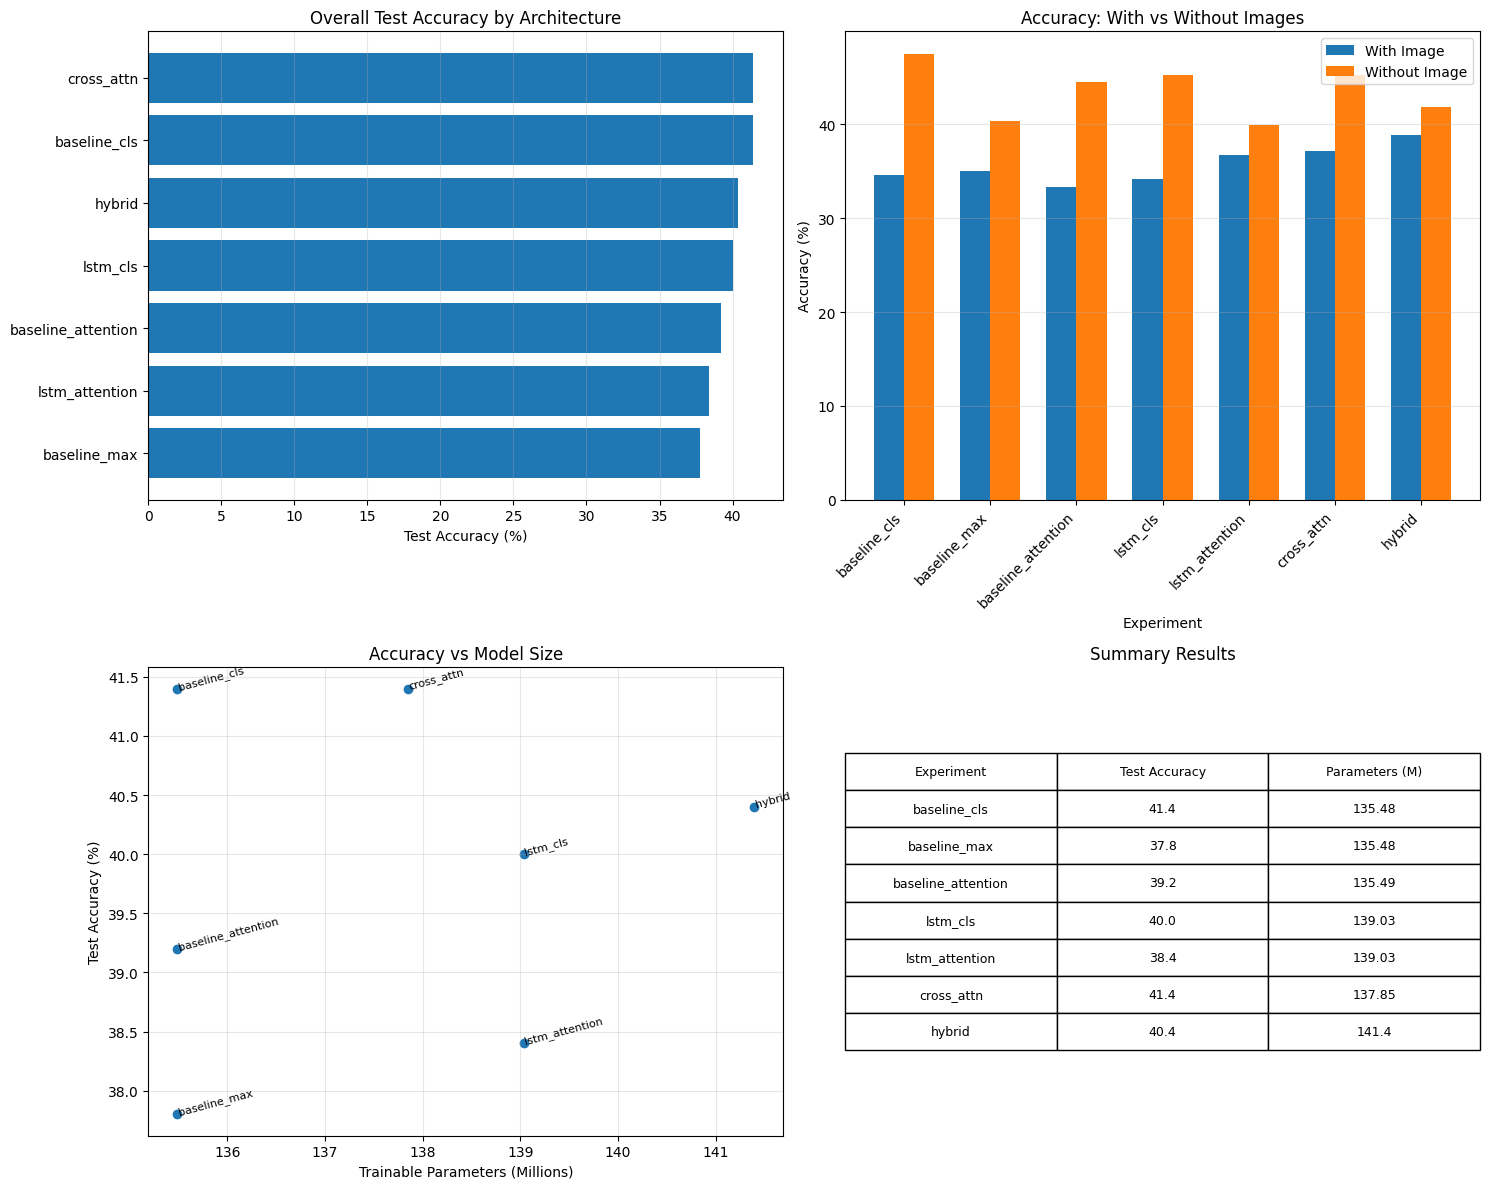

In [ ]:
# ==================== VIEW RESULTS ====================

# Show results
if len(runner.results) > 0:
    print("\n" + "="*60)
    print("RESULTS SUMMARY")
    print("="*60)

    for r in runner.results:
        print(f"\n{r['experiment_name']}:")
        print(f"  Test Accuracy: {r['test_acc']:.2%}")
        print(f"  With Image: {r['test_breakdown'].get('with_image', 0):.2%}")
        print(f"  Without Image: {r['test_breakdown'].get('without_image', 0):.2%}")

# Plot comparison if multiple experiments
if len(runner.results) > 1:
    runner.plot_comparison()

print("\n✅ DONE!")

In [ ]:
# ==================== VIEW RESULTS ==================== original one exp

# Show results
if len(runner.results) > 0:
    print("\n" + "="*60)
    print("RESULTS SUMMARY")
    print("="*60)

    for r in runner.results:
        print(f"\n{r['experiment_name']}:")
        print(f"  Test Accuracy: {r['test_acc']:.2%}")
        print(f"  With Image: {r['test_breakdown'].get('with_image', 0):.2%}")
        print(f"  Without Image: {r['test_breakdown'].get('without_image', 0):.2%}")

# Plot comparison if multiple experiments
if len(runner.results) > 1:
    runner.plot_comparison()

print("\n✅ DONE!")


RESULTS SUMMARY

baseline_cls:
  Test Accuracy: 41.40%
  With Image: 34.60%
  Without Image: 47.53%

✅ DONE!


# Paper metrics

In [ ]:
train_dataset = ScienceQADataset(dataset['train'], tokenizer, transform)
val_dataset = ScienceQADataset(dataset['validation'], tokenizer, transform)
test_dataset = ScienceQADataset(dataset['test'], tokenizer, transform)

# Recreate dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


In [ ]:
# ==================== EXACT EVALUATION MATCHING YOUR ORIGINAL CODE ====================

def evaluate_with_breakdown(model, dataloader, device):
    """
    Evaluate model with exact same breakdown as original VLM code.
    Returns: results dict, responses list, predictions array, labels array
    """
    model.eval()

    # Store results
    all_predictions = []
    all_labels = []
    all_subjects = []
    all_has_image = []
    all_has_text = []
    all_grades = []
    all_responses = []  # For debugging (we'll store logits here)

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            has_image = batch['has_image'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            logits = model(input_ids, attention_mask, images, has_image)
            preds = torch.argmax(logits, dim=1)

            # Store results
            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_subjects.extend(batch['subject'])
            all_has_image.extend(has_image.cpu().numpy())
            all_has_text.extend(batch['has_text'].cpu().numpy())
            all_grades.extend(batch['grade'])

            # Store top predictions as "responses" for debugging
            top_preds = torch.topk(logits, k=1, dim=1)
            all_responses.extend([f"Prediction: {p.item()}" for p in preds])

    # Convert to numpy
    predictions = np.array(all_predictions)
    labels = np.array(all_labels)
    subjects = np.array(all_subjects)
    has_image = np.array(all_has_image)
    has_text = np.array(all_has_text)
    grades = np.array(all_grades)

    # Calculate metrics (EXACT SAME LOGIC AS YOUR ORIGINAL)
    results = {}

    # Overall accuracy (excluding failed extractions)
    valid_mask = predictions >= 0  # All predictions are valid in our case
    overall_acc = (predictions[valid_mask] == labels[valid_mask]).mean() * 100
    results['Overall'] = overall_acc
    results['Valid_predictions'] = valid_mask.sum() / len(predictions) * 100

    # By Subject - EXACT SAME AS ORIGINAL
    for subject in ['natural science', 'social science', 'language science']:
        mask = (subjects == subject) & valid_mask
        if mask.sum() > 0:
            acc = (predictions[mask] == labels[mask]).mean() * 100
            results[subject.upper()[:3]] = acc  # NAT, SOC, LAN

    # By Context Type - EXACT SAME AS ORIGINAL
    # Text context only
    mask = has_text & ~has_image & valid_mask
    if mask.sum() > 0:
        results['TXT'] = (predictions[mask] == labels[mask]).mean() * 100

    # Image context only
    mask = has_image & ~has_text & valid_mask
    if mask.sum() > 0:
        results['IMG'] = (predictions[mask] == labels[mask]).mean() * 100

    # No context
    mask = ~has_image & ~has_text & valid_mask
    if mask.sum() > 0:
        results['NO'] = (predictions[mask] == labels[mask]).mean() * 100

    # Both contexts
    mask = has_image & has_text & valid_mask
    if mask.sum() > 0:
        results['TXT+IMG'] = (predictions[mask] == labels[mask]).mean() * 100

    # By Grade Group - EXACT SAME AS ORIGINAL
    grade_nums = []
    for g in grades:
        try:
            grade_nums.append(int(g.replace('grade', '')))
        except:
            grade_nums.append(0)
    grade_nums = np.array(grade_nums)

    # G1-6 (elementary)
    mask = (grade_nums >= 1) & (grade_nums <= 6) & valid_mask
    if mask.sum() > 0:
        results['G1-6'] = (predictions[mask] == labels[mask]).mean() * 100

    # G7-12 (secondary)
    mask = (grade_nums >= 7) & (grade_nums <= 12) & valid_mask
    if mask.sum() > 0:
        results['G7-12'] = (predictions[mask] == labels[mask]).mean() * 100

    return results, all_responses, predictions, labels




In [ ]:
# ==================== UPDATE EXPERIMENT RUNNER ====================

class ExperimentRunner:
    """Manages multiple experiments and tracks results"""

    def __init__(self, output_dir="experiments"):
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)
        self.results = []

    def run_experiment(
        self,
        experiment_name,
        model_config,
        train_loader,
        val_loader,
        test_loader,
        num_epochs=5,
        learning_rate=2e-5,
        device='cuda'
    ):
        """Run single experiment"""
        print(f"\n{'='*60}")
        print(f"EXPERIMENT: {experiment_name}")
        print(f"{'='*60}")
        print(f"Config: {model_config}")

        # Initialize model
        model = MultimodalQA(**model_config).to(device)

        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")

        # Optimizer and scheduler
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
        total_steps = len(train_loader) * num_epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=500,
            num_training_steps=total_steps
        )

        # Training loop
        best_val_acc = 0
        start_time = datetime.now()

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")

            train_loss, train_acc = train_epoch(
                model, train_loader, optimizer, scheduler, device
            )

            # Validation with breakdown
            val_results, _, val_preds, val_labels = evaluate_with_breakdown(
                model, val_loader, device
            )
            val_acc = val_results['Overall'] / 100

            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
            print(f"Val Overall: {val_results['Overall']:.2f}%")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(
                    model.state_dict(),
                    self.output_dir / f"{experiment_name}_best.pt"
                )

        # Final evaluation on test set
        print("\nEvaluating on test set...")
        test_results, test_responses, test_preds, test_labels = evaluate_with_breakdown(
            model, test_loader, device
        )

        training_time = (datetime.now() - start_time).total_seconds()

        # Print detailed results
        self.print_detailed_results(experiment_name, test_results, test_preds, test_labels)

        # Store results
        result = {
            'experiment_name': experiment_name,
            'config': model_config,
            'total_params': total_params,
            'trainable_params': trainable_params,
            'best_val_acc': best_val_acc,
            'test_acc': test_results['Overall'] / 100,
            'test_breakdown': test_results,
            'training_time_seconds': training_time
        }
        self.results.append(result)

        # Save results
        self.save_results()

        print(f"\n{'='*60}")
        print(f"RESULTS: {experiment_name}")
        print(f"Test Accuracy: {test_results['Overall']:.2f}%")
        print(f"Training Time: {training_time:.2f}s")
        print(f"{'='*60}\n")

        return result

    def print_detailed_results(self, experiment_name, results, preds, labels):
        """Print detailed results EXACTLY like your original file"""

        print("\n" + "="*60)
        print(f"📊 EVALUATION RESULTS - ScienceQA Test Set")
        print("="*60)

        # Overall Performance
        print("\n🎯 OVERALL PERFORMANCE:")
        print("-" * 40)
        print(f"Overall Accuracy:      {results['Overall']:.2f}%")
        print(f"Valid Predictions:     {results['Valid_predictions']:.2f}%")
        print(f"Failed Extractions:    {100 - results['Valid_predictions']:.2f}%")

        # By Subject
        print("\n📚 ACCURACY BY SUBJECT:")
        print("-" * 40)
        subject_results = {
            'Natural Science': results.get('NAT', 0),
            'Social Science': results.get('SOC', 0),
            'Language Science': results.get('LAN', 0)
        }
        for subject, acc in subject_results.items():
            if acc > 0:
                print(f"{subject:20s}: {acc:6.2f}%")

        # By Context Type
        print("\n🔍 ACCURACY BY CONTEXT TYPE:")
        print("-" * 40)
        context_results = {
            'Text Only': results.get('TXT', 0),
            'Image Only': results.get('IMG', 0),
            'No Context': results.get('NO', 0),
            'Text + Image': results.get('TXT+IMG', 0)
        }
        for context, acc in context_results.items():
            if acc > 0:
                bar = '█' * int(acc / 2)
                print(f"{context:20s}: {acc:6.2f}% {bar}")

        # By Grade Level
        print("\n🎓 ACCURACY BY GRADE LEVEL:")
        print("-" * 40)
        grade_results = {
            'Elementary (G1-6)': results.get('G1-6', 0),
            'Secondary (G7-12)': results.get('G7-12', 0)
        }
        for grade, acc in grade_results.items():
            if acc > 0:
                print(f"{grade:20s}: {acc:6.2f}%")

        # Detailed Table
        print("\n📋 DETAILED RESULTS TABLE:")
        print("-" * 60)
        results_data = []
        for key, value in results.items():
            if key not in ['Overall', 'Valid_predictions']:
                results_data.append({'Metric': key, 'Accuracy (%)': f"{value:.2f}"})

        df_results = pd.DataFrame(results_data)
        print(df_results.to_string(index=False))

        # Confusion Analysis
        print("\n🔬 PREDICTION ANALYSIS:")
        print("-" * 40)
        valid_mask = preds >= 0
        total_predictions = len(preds)
        correct_predictions = (preds[valid_mask] == labels[valid_mask]).sum()
        wrong_predictions = (preds[valid_mask] != labels[valid_mask]).sum()
        failed_predictions = (~valid_mask).sum()

        print(f"Total Questions:       {total_predictions:5d}")
        print(f"Correct Predictions:   {correct_predictions:5d} ({correct_predictions/total_predictions*100:5.2f}%)")
        print(f"Wrong Predictions:     {wrong_predictions:5d} ({wrong_predictions/total_predictions*100:5.2f}%)")
        print(f"Failed Extractions:    {failed_predictions:5d} ({failed_predictions/total_predictions*100:5.2f}%)")

    def save_results(self):
        """Save all results to JSON and CSV"""
        # JSON for full details
        with open(self.output_dir / 'results.json', 'w') as f:
            json.dump(self.results, f, indent=2)

        # CSV for easy comparison - with ALL the metrics you want
        df = pd.DataFrame([{
            'experiment': r['experiment_name'],
            'pooling': r['config'].get('pooling_strategy', 'N/A'),
            'use_lstm': r['config'].get('use_lstm', False),
            'use_cross_attn': r['config'].get('use_cross_attention', False),
            'overall': f"{r['test_breakdown']['Overall']:.2f}",
            'NAT': f"{r['test_breakdown'].get('NAT', 0):.2f}",
            'SOC': f"{r['test_breakdown'].get('SOC', 0):.2f}",
            'LAN': f"{r['test_breakdown'].get('LAN', 0):.2f}",
            'TXT': f"{r['test_breakdown'].get('TXT', 0):.2f}",
            'IMG': f"{r['test_breakdown'].get('IMG', 0):.2f}",
            'NO': f"{r['test_breakdown'].get('NO', 0):.2f}",
            'TXT+IMG': f"{r['test_breakdown'].get('TXT+IMG', 0):.2f}",
            'G1-6': f"{r['test_breakdown'].get('G1-6', 0):.2f}",
            'G7-12': f"{r['test_breakdown'].get('G7-12', 0):.2f}",
            'params_M': f"{r['trainable_params'] / 1e6:.1f}",
            'time_s': f"{r['training_time_seconds']:.1f}"
        } for r in self.results])

        df.to_csv(self.output_dir / 'results.csv', index=False)
        print(f"\n💾 Results saved to {self.output_dir}")

    def plot_comparison(self):
        """Create comparison visualizations"""
        if len(self.results) < 2:
            return

        # Create comparison plot
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # 1. Overall accuracy
        ax1 = axes[0, 0]
        exp_names = [r['experiment_name'] for r in self.results]
        overall_accs = [r['test_breakdown']['Overall'] for r in self.results]
        ax1.barh(exp_names, overall_accs)
        ax1.set_xlabel('Overall Accuracy (%)')
        ax1.set_title('Overall Test Accuracy by Architecture')
        ax1.grid(axis='x', alpha=0.3)

        # 2. Context type comparison
        ax2 = axes[0, 1]
        contexts = ['TXT', 'IMG', 'NO', 'TXT+IMG']
        x = np.arange(len(self.results))
        width = 0.2
        for i, ctx in enumerate(contexts):
            accs = [r['test_breakdown'].get(ctx, 0) for r in self.results]
            ax2.bar(x + i*width, accs, width, label=ctx)
        ax2.set_xlabel('Experiment')
        ax2.set_ylabel('Accuracy (%)')
        ax2.set_title('Accuracy by Context Type')
        ax2.set_xticks(x + width * 1.5)
        ax2.set_xticklabels([r['experiment_name'] for r in self.results], rotation=45, ha='right')
        ax2.legend()
        ax2.grid(axis='y', alpha=0.3)

        # 3. Subject comparison
        ax3 = axes[1, 0]
        subjects = ['NAT', 'SOC', 'LAN']
        x = np.arange(len(self.results))
        width = 0.25
        for i, subj in enumerate(subjects):
            accs = [r['test_breakdown'].get(subj, 0) for r in self.results]
            ax3.bar(x + i*width, accs, width, label=subj)
        ax3.set_xlabel('Experiment')
        ax3.set_ylabel('Accuracy (%)')
        ax3.set_title('Accuracy by Subject')
        ax3.set_xticks(x + width)
        ax3.set_xticklabels([r['experiment_name'] for r in self.results], rotation=45, ha='right')
        ax3.legend()
        ax3.grid(axis='y', alpha=0.3)

        # 4. Summary table
        ax4 = axes[1, 1]
        ax4.axis('off')
        table_data = [[r['experiment_name'],
                      f"{r['test_breakdown']['Overall']:.1f}%",
                      f"{r['trainable_params']/1e6:.1f}M"]
                     for r in self.results]
        table = ax4.table(cellText=table_data,
                         colLabels=['Experiment', 'Accuracy', 'Params'],
                         cellLoc='center',
                         loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 2)
        ax4.set_title('Summary Results')

        plt.tight_layout()
        plt.savefig(self.output_dir / 'comparison.png', dpi=300, bbox_inches='tight')
        print(f"📊 Comparison plot saved to {self.output_dir / 'comparison.png'}")

In [ ]:
# ==================== RUN ALL EXPERIMENTS ====================

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load dataset
print("Loading ScienceQA dataset...")
dataset = load_dataset("derek-thomas/ScienceQA")

# # For quick testing (remove these 3 lines for full dataset)
# dataset['train'] = dataset['train'].select(range(1000))
dataset['validation'] = dataset['validation'].select(range(500))
dataset['test'] = dataset['test'].select(range(500))

print(f"len of train {len(dataset['train'])}")
print(f"len of val {len(dataset['validation'])}")
print(f"len of test {len(dataset['test'])}")

# Tokenizer and transforms
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = ScienceQADataset(dataset['train'], tokenizer, transform)
val_dataset = ScienceQADataset(dataset['validation'], tokenizer, transform)
test_dataset = ScienceQADataset(dataset['test'], tokenizer, transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

# Initialize experiment runner
runner = ExperimentRunner()

Using device: cuda
Loading ScienceQA dataset...
len of train 12726
len of val 500
len of test 500


In [ ]:
experiments = {
    'baseline_cls': {'pooling_strategy': 'cls', 'use_lstm': False, 'use_cross_attention': False},
    'baseline_attention': {'pooling_strategy': 'attention', 'use_lstm': False, 'use_cross_attention': False},
    'lstm_attention': {'pooling_strategy': 'attention', 'use_lstm': True, 'use_cross_attention': False},
    'cross_attn': {'pooling_strategy': 'attention', 'use_lstm': False, 'use_cross_attention': True},
    'hybrid': {'pooling_strategy': 'attention', 'use_lstm': True, 'use_cross_attention': True}
}

In [ ]:
exp_name = 'baseline_cls'  # Change this to run different ones
runner.run_experiment(
    experiment_name=exp_name,
    model_config=experiments[exp_name],
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=5,
    learning_rate=2e-5,
    device=device
)


EXPERIMENT: baseline_cls
Config: {'pooling_strategy': 'cls', 'use_lstm': False, 'use_cross_attention': False}
Total parameters: 135,484,997
Trainable parameters: 135,484,997

Epoch 1/5


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.78it/s]


Train Loss: 1.1223, Train Acc: 0.3821
Val Overall: 40.40%

Epoch 2/5


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.77it/s]


Train Loss: 0.9898, Train Acc: 0.4064
Val Overall: 43.20%

Epoch 3/5


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.75it/s]


Train Loss: 0.9613, Train Acc: 0.4389
Val Overall: 47.00%

Epoch 4/5


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.79it/s]


Train Loss: 0.8895, Train Acc: 0.5128
Val Overall: 53.20%

Epoch 5/5


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.75it/s]


Train Loss: 0.7700, Train Acc: 0.6025
Val Overall: 58.20%

Evaluating on test set...


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.79it/s]


📊 EVALUATION RESULTS - ScienceQA Test Set

🎯 OVERALL PERFORMANCE:
----------------------------------------
Overall Accuracy:      52.00%
Valid Predictions:     100.00%
Failed Extractions:    0.00%

📚 ACCURACY BY SUBJECT:
----------------------------------------
Natural Science     :  53.58%
Social Science      :  58.25%
Language Science    :  43.94%

🔍 ACCURACY BY CONTEXT TYPE:
----------------------------------------
Text Only           :  58.16% █████████████████████████████
Image Only          :  54.44% ███████████████████████████
No Context          :  43.64% █████████████████████
Text + Image        :  55.78% ███████████████████████████

🎓 ACCURACY BY GRADE LEVEL:
----------------------------------------
Elementary (G1-6)   :  53.58%
Secondary (G7-12)   :  49.16%

📋 DETAILED RESULTS TABLE:
------------------------------------------------------------
 Metric Accuracy (%)
    NAT        53.58
    SOC        58.25
    LAN        43.94
    TXT        58.16
    IMG        54.44
     N

{'experiment_name': 'baseline_cls',
 'config': {'pooling_strategy': 'cls',
  'use_lstm': False,
  'use_cross_attention': False},
 'total_params': 135484997,
 'trainable_params': 135484997,
 'best_val_acc': np.float64(0.582),
 'test_acc': np.float64(0.52),
 'test_breakdown': {'Overall': np.float64(52.0),
  'Valid_predictions': np.float64(100.0),
  'NAT': np.float64(53.58490566037736),
  'SOC': np.float64(58.252427184466015),
  'LAN': np.float64(43.93939393939394),
  'TXT': np.float64(58.16326530612245),
  'IMG': np.float64(54.44444444444444),
  'NO': np.float64(43.63636363636363),
  'TXT+IMG': np.float64(55.78231292517006),
  'G1-6': np.float64(53.58255451713395),
  'G7-12': np.float64(49.162011173184354)},
 'training_time_seconds': 1541.544911}

In [ ]:
# exp_name = 'baseline_max'  # Change this to run different ones
# runner.run_experiment(
#     experiment_name=exp_name,
#     model_config=experiments[exp_name],
#     train_loader=train_loader,
#     val_loader=val_loader,
#     test_loader=test_loader,
#     num_epochs=5,
#     learning_rate=2e-5,
#     device=device
# )

In [ ]:
exp_name = 'baseline_attention'  # Change this to run different ones
runner.run_experiment(
    experiment_name=exp_name,
    model_config=experiments[exp_name],
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=5,
    learning_rate=2e-5,
    device=device
)


EXPERIMENT: baseline_attention
Config: {'pooling_strategy': 'attention', 'use_lstm': False, 'use_cross_attention': False}
Total parameters: 135,485,766
Trainable parameters: 135,485,766

Epoch 1/5


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.74it/s]


Train Loss: 1.0993, Train Acc: 0.4008
Val Overall: 47.60%

Epoch 2/5


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.79it/s]


Train Loss: 0.9871, Train Acc: 0.4127
Val Overall: 38.40%

Epoch 3/5


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.75it/s]


Train Loss: 0.9707, Train Acc: 0.4223
Val Overall: 42.20%

Epoch 4/5


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.76it/s]


Train Loss: 0.9300, Train Acc: 0.4915
Val Overall: 48.00%

Epoch 5/5


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.77it/s]


Train Loss: 0.8622, Train Acc: 0.5525
Val Overall: 46.00%

Evaluating on test set...


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.77it/s]


📊 EVALUATION RESULTS - ScienceQA Test Set

🎯 OVERALL PERFORMANCE:
----------------------------------------
Overall Accuracy:      43.00%
Valid Predictions:     100.00%
Failed Extractions:    0.00%

📚 ACCURACY BY SUBJECT:
----------------------------------------
Natural Science     :  45.66%
Social Science      :  28.16%
Language Science    :  49.24%

🔍 ACCURACY BY CONTEXT TYPE:
----------------------------------------
Text Only           :  47.96% ███████████████████████
Image Only          :  24.44% ████████████
No Context          :  46.67% ███████████████████████
Text + Image        :  46.94% ███████████████████████

🎓 ACCURACY BY GRADE LEVEL:
----------------------------------------
Elementary (G1-6)   :  42.68%
Secondary (G7-12)   :  43.58%

📋 DETAILED RESULTS TABLE:
------------------------------------------------------------
 Metric Accuracy (%)
    NAT        45.66
    SOC        28.16
    LAN        49.24
    TXT        47.96
    IMG        24.44
     NO        46.67
TXT+IMG 

{'experiment_name': 'baseline_attention',
 'config': {'pooling_strategy': 'attention',
  'use_lstm': False,
  'use_cross_attention': False},
 'total_params': 135485766,
 'trainable_params': 135485766,
 'best_val_acc': np.float64(0.48),
 'test_acc': np.float64(0.43),
 'test_breakdown': {'Overall': np.float64(43.0),
  'Valid_predictions': np.float64(100.0),
  'NAT': np.float64(45.660377358490564),
  'SOC': np.float64(28.155339805825243),
  'LAN': np.float64(49.24242424242424),
  'TXT': np.float64(47.95918367346938),
  'IMG': np.float64(24.444444444444443),
  'NO': np.float64(46.666666666666664),
  'TXT+IMG': np.float64(46.93877551020408),
  'G1-6': np.float64(42.679127725856695),
  'G7-12': np.float64(43.575418994413404)},
 'training_time_seconds': 1539.535976}

In [ ]:
# exp_name = 'lstm_cls'  # Change this to run different ones
# runner.run_experiment(
#     experiment_name=exp_name,
#     model_config=experiments[exp_name],
#     train_loader=train_loader,
#     val_loader=val_loader,
#     test_loader=test_loader,
#     num_epochs=5,
#     learning_rate=2e-5,
#     device=device
# )

In [ ]:
exp_name = 'lstm_attention'  # Change this to run different ones
runner.run_experiment(
    experiment_name=exp_name,
    model_config=experiments[exp_name],
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=5,
    learning_rate=2e-5,
    device=device
)


EXPERIMENT: lstm_attention
Config: {'pooling_strategy': 'attention', 'use_lstm': True, 'use_cross_attention': False}
Total parameters: 139,033,926
Trainable parameters: 139,033,926

Epoch 1/5


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.31it/s]


Train Loss: 1.1056, Train Acc: 0.3931
Val Overall: 35.20%

Epoch 2/5


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.33it/s]


Train Loss: 0.9870, Train Acc: 0.4121
Val Overall: 37.40%

Epoch 3/5


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.33it/s]


Train Loss: 0.9683, Train Acc: 0.4261
Val Overall: 44.40%

Epoch 4/5


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.33it/s]


Train Loss: 0.9371, Train Acc: 0.4759
Val Overall: 49.80%

Epoch 5/5


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.32it/s]


Train Loss: 0.8685, Train Acc: 0.5499
Val Overall: 50.40%

Evaluating on test set...


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.30it/s]


📊 EVALUATION RESULTS - ScienceQA Test Set

🎯 OVERALL PERFORMANCE:
----------------------------------------
Overall Accuracy:      46.20%
Valid Predictions:     100.00%
Failed Extractions:    0.00%

📚 ACCURACY BY SUBJECT:
----------------------------------------
Natural Science     :  46.42%
Social Science      :  43.69%
Language Science    :  47.73%

🔍 ACCURACY BY CONTEXT TYPE:
----------------------------------------
Text Only           :  48.98% ████████████████████████
Image Only          :  34.44% █████████████████
No Context          :  46.67% ███████████████████████
Text + Image        :  51.02% █████████████████████████

🎓 ACCURACY BY GRADE LEVEL:
----------------------------------------
Elementary (G1-6)   :  47.98%
Secondary (G7-12)   :  43.02%

📋 DETAILED RESULTS TABLE:
------------------------------------------------------------
 Metric Accuracy (%)
    NAT        46.42
    SOC        43.69
    LAN        47.73
    TXT        48.98
    IMG        34.44
     NO        46.67


{'experiment_name': 'lstm_attention',
 'config': {'pooling_strategy': 'attention',
  'use_lstm': True,
  'use_cross_attention': False},
 'total_params': 139033926,
 'trainable_params': 139033926,
 'best_val_acc': np.float64(0.504),
 'test_acc': np.float64(0.462),
 'test_breakdown': {'Overall': np.float64(46.2),
  'Valid_predictions': np.float64(100.0),
  'NAT': np.float64(46.41509433962264),
  'SOC': np.float64(43.689320388349515),
  'LAN': np.float64(47.72727272727273),
  'TXT': np.float64(48.97959183673469),
  'IMG': np.float64(34.44444444444444),
  'NO': np.float64(46.666666666666664),
  'TXT+IMG': np.float64(51.02040816326531),
  'G1-6': np.float64(47.97507788161994),
  'G7-12': np.float64(43.01675977653631)},
 'training_time_seconds': 1669.320914}

In [ ]:
exp_name = 'cross_attn'  # Change this to run different ones
runner.run_experiment(
    experiment_name=exp_name,
    model_config=experiments[exp_name],
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=5,
    learning_rate=2e-5,
    device=device
)


EXPERIMENT: cross_attn
Config: {'pooling_strategy': 'attention', 'use_lstm': False, 'use_cross_attention': True}
Total parameters: 137,849,670
Trainable parameters: 137,849,670

Epoch 1/5


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.66it/s]


Train Loss: 1.0837, Train Acc: 0.3956
Val Overall: 45.60%

Epoch 2/5


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.63it/s]


Train Loss: 0.9837, Train Acc: 0.4143
Val Overall: 45.40%

Epoch 3/5


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.64it/s]


Train Loss: 0.9673, Train Acc: 0.4268
Val Overall: 45.00%

Epoch 4/5


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.60it/s]


Train Loss: 0.9337, Train Acc: 0.4774
Val Overall: 42.60%

Epoch 5/5


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.63it/s]


Train Loss: 0.8769, Train Acc: 0.5460
Val Overall: 46.20%

Evaluating on test set...


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.63it/s]


📊 EVALUATION RESULTS - ScienceQA Test Set

🎯 OVERALL PERFORMANCE:
----------------------------------------
Overall Accuracy:      49.40%
Valid Predictions:     100.00%
Failed Extractions:    0.00%

📚 ACCURACY BY SUBJECT:
----------------------------------------
Natural Science     :  53.96%
Social Science      :  39.81%
Language Science    :  47.73%

🔍 ACCURACY BY CONTEXT TYPE:
----------------------------------------
Text Only           :  60.20% ██████████████████████████████
Image Only          :  35.56% █████████████████
No Context          :  45.45% ██████████████████████
Text + Image        :  55.10% ███████████████████████████

🎓 ACCURACY BY GRADE LEVEL:
----------------------------------------
Elementary (G1-6)   :  52.02%
Secondary (G7-12)   :  44.69%

📋 DETAILED RESULTS TABLE:
------------------------------------------------------------
 Metric Accuracy (%)
    NAT        53.96
    SOC        39.81
    LAN        47.73
    TXT        60.20
    IMG        35.56
     NO       

{'experiment_name': 'cross_attn',
 'config': {'pooling_strategy': 'attention',
  'use_lstm': False,
  'use_cross_attention': True},
 'total_params': 137849670,
 'trainable_params': 137849670,
 'best_val_acc': np.float64(0.462),
 'test_acc': np.float64(0.494),
 'test_breakdown': {'Overall': np.float64(49.4),
  'Valid_predictions': np.float64(100.0),
  'NAT': np.float64(53.9622641509434),
  'SOC': np.float64(39.80582524271845),
  'LAN': np.float64(47.72727272727273),
  'TXT': np.float64(60.204081632653065),
  'IMG': np.float64(35.55555555555556),
  'NO': np.float64(45.45454545454545),
  'TXT+IMG': np.float64(55.10204081632652),
  'G1-6': np.float64(52.024922118380054),
  'G7-12': np.float64(44.6927374301676)},
 'training_time_seconds': 1556.578116}

In [ ]:
exp_name = 'hybrid'  # Change this to run different ones
runner.run_experiment(
    experiment_name=exp_name,
    model_config=experiments[exp_name],
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=5,
    learning_rate=2e-5,
    device=device
)


EXPERIMENT: hybrid
Config: {'pooling_strategy': 'attention', 'use_lstm': True, 'use_cross_attention': True}
Total parameters: 141,397,830
Trainable parameters: 141,397,830

Epoch 1/5


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.25it/s]


Train Loss: 1.1114, Train Acc: 0.3839
Val Overall: 36.40%

Epoch 2/5


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.26it/s]


Train Loss: 0.9850, Train Acc: 0.4058
Val Overall: 44.80%

Epoch 3/5


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.26it/s]


Train Loss: 0.9704, Train Acc: 0.4225
Val Overall: 41.00%

Epoch 4/5


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.25it/s]


Train Loss: 0.9373, Train Acc: 0.4573
Val Overall: 49.20%

Epoch 5/5


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.25it/s]


Train Loss: 0.8906, Train Acc: 0.5165
Val Overall: 50.40%

Evaluating on test set...


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.23it/s]


📊 EVALUATION RESULTS - ScienceQA Test Set

🎯 OVERALL PERFORMANCE:
----------------------------------------
Overall Accuracy:      48.80%
Valid Predictions:     100.00%
Failed Extractions:    0.00%

📚 ACCURACY BY SUBJECT:
----------------------------------------
Natural Science     :  53.96%
Social Science      :  39.81%
Language Science    :  45.45%

🔍 ACCURACY BY CONTEXT TYPE:
----------------------------------------
Text Only           :  61.22% ██████████████████████████████
Image Only          :  37.78% ██████████████████
No Context          :  44.24% ██████████████████████
Text + Image        :  52.38% ██████████████████████████

🎓 ACCURACY BY GRADE LEVEL:
----------------------------------------
Elementary (G1-6)   :  52.34%
Secondary (G7-12)   :  42.46%

📋 DETAILED RESULTS TABLE:
------------------------------------------------------------
 Metric Accuracy (%)
    NAT        53.96
    SOC        39.81
    LAN        45.45
    TXT        61.22
    IMG        37.78
     NO       

{'experiment_name': 'hybrid',
 'config': {'pooling_strategy': 'attention',
  'use_lstm': True,
  'use_cross_attention': True},
 'total_params': 141397830,
 'trainable_params': 141397830,
 'best_val_acc': np.float64(0.504),
 'test_acc': np.float64(0.488),
 'test_breakdown': {'Overall': np.float64(48.8),
  'Valid_predictions': np.float64(100.0),
  'NAT': np.float64(53.9622641509434),
  'SOC': np.float64(39.80582524271845),
  'LAN': np.float64(45.45454545454545),
  'TXT': np.float64(61.224489795918366),
  'IMG': np.float64(37.77777777777778),
  'NO': np.float64(44.24242424242424),
  'TXT+IMG': np.float64(52.38095238095239),
  'G1-6': np.float64(52.336448598130836),
  'G7-12': np.float64(42.45810055865922)},
 'training_time_seconds': 1689.775975}

📊 Comparison plot saved to experiments/comparison.png

ALL EXPERIMENTS SUMMARY

baseline_cls:
  Overall: 52.00%
  NAT: 53.58%
  IMG: 54.44%

baseline_attention:
  Overall: 43.00%
  NAT: 45.66%
  IMG: 24.44%

lstm_attention:
  Overall: 46.20%
  NAT: 46.42%
  IMG: 34.44%

cross_attn:
  Overall: 49.40%
  NAT: 53.96%
  IMG: 35.56%

hybrid:
  Overall: 48.80%
  NAT: 53.96%
  IMG: 37.78%

📁 Results saved to:
  - experiments/results.json
  - experiments/results.csv
  - experiments/comparison.png


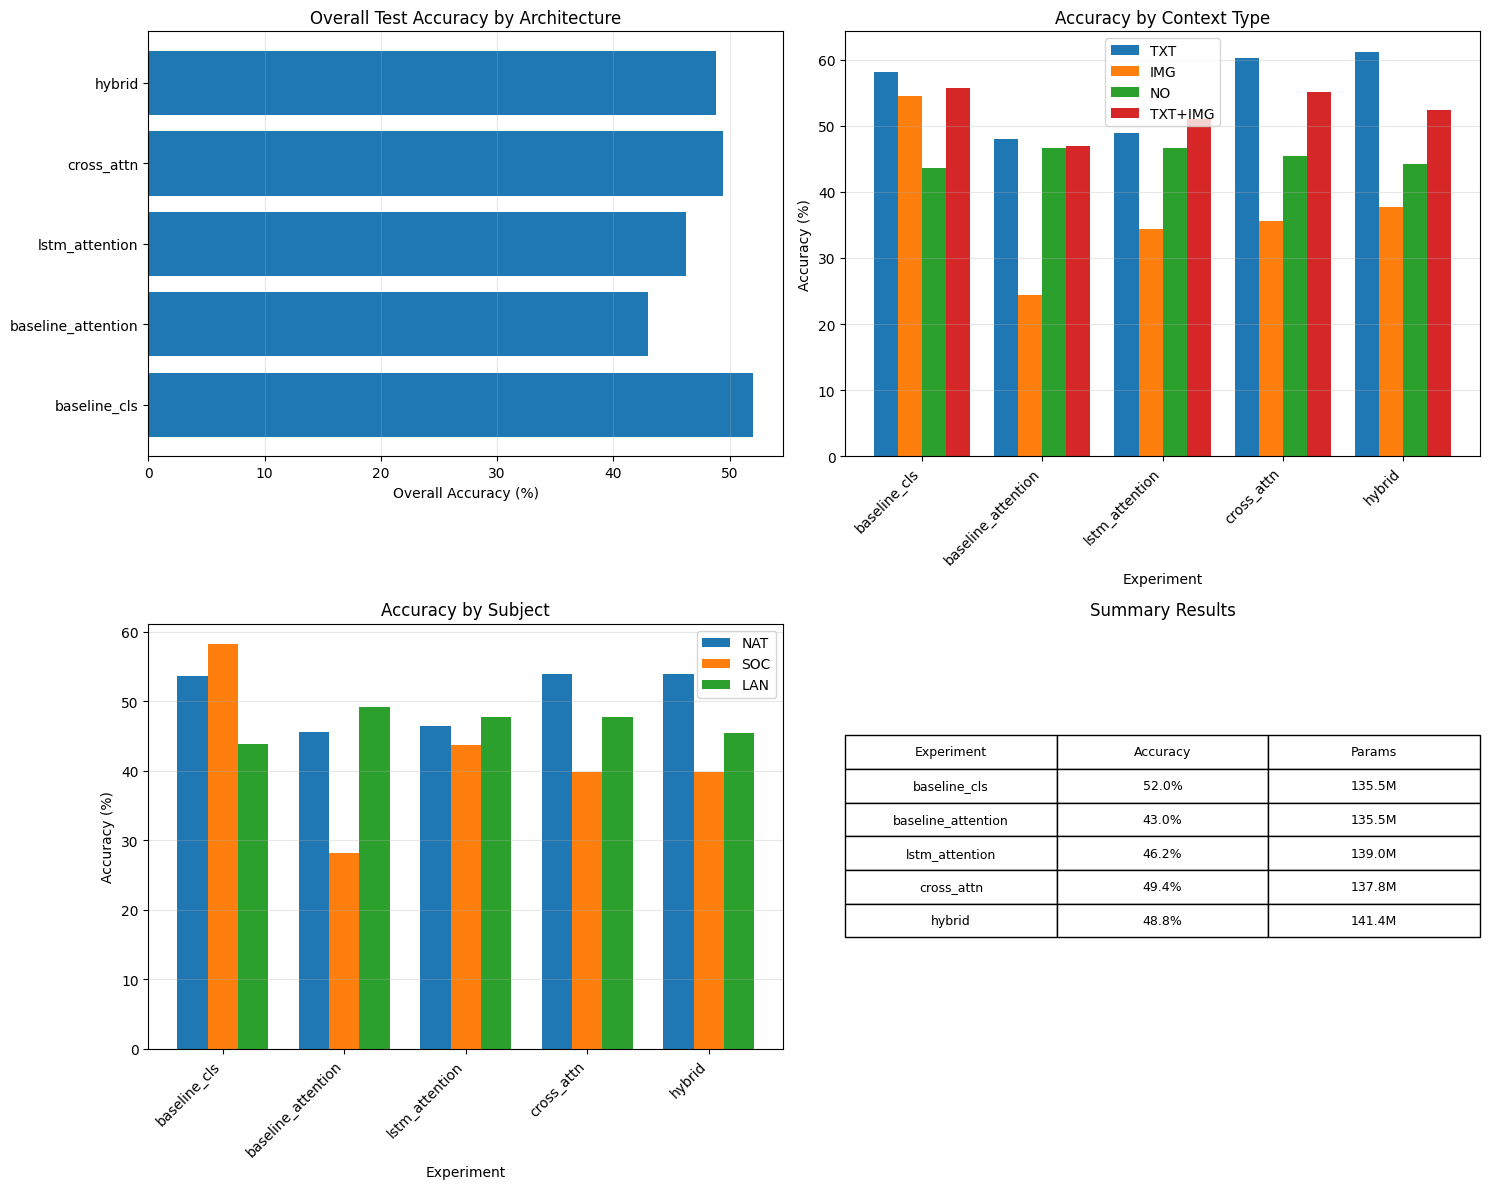

In [ ]:
# ==================== PLOT RESULTS ====================
if len(runner.results) > 1:
    runner.plot_comparison()

# ==================== VIEW RESULTS ====================
print("\n" + "="*60)
print("ALL EXPERIMENTS SUMMARY")
print("="*60)
for r in runner.results:
    print(f"\n{r['experiment_name']}:")
    print(f"  Overall: {r['test_breakdown']['Overall']:.2f}%")
    print(f"  NAT: {r['test_breakdown'].get('NAT', 0):.2f}%")
    print(f"  IMG: {r['test_breakdown'].get('IMG', 0):.2f}%")

# Check saved files
print("\n📁 Results saved to:")
print("  - experiments/results.json")
print("  - experiments/results.csv")
print("  - experiments/comparison.png")


In [ ]:
# Filter out baseline_cls
filtered_results = [r for r in runner.results if r['experiment_name'] != 'baseline_cls']

📊 Comparison plot saved to experiments/comparison.png

ALL EXPERIMENTS SUMMARY

baseline_cls:
  Overall: 52.00%
  NAT: 53.58%
  IMG: 54.44%

baseline_attention:
  Overall: 43.00%
  NAT: 45.66%
  IMG: 24.44%

lstm_attention:
  Overall: 46.20%
  NAT: 46.42%
  IMG: 34.44%

cross_attn:
  Overall: 49.40%
  NAT: 53.96%
  IMG: 35.56%

hybrid:
  Overall: 48.80%
  NAT: 53.96%
  IMG: 37.78%

📁 Results saved to:
  - experiments/results.json
  - experiments/results.csv
  - experiments/comparison.png


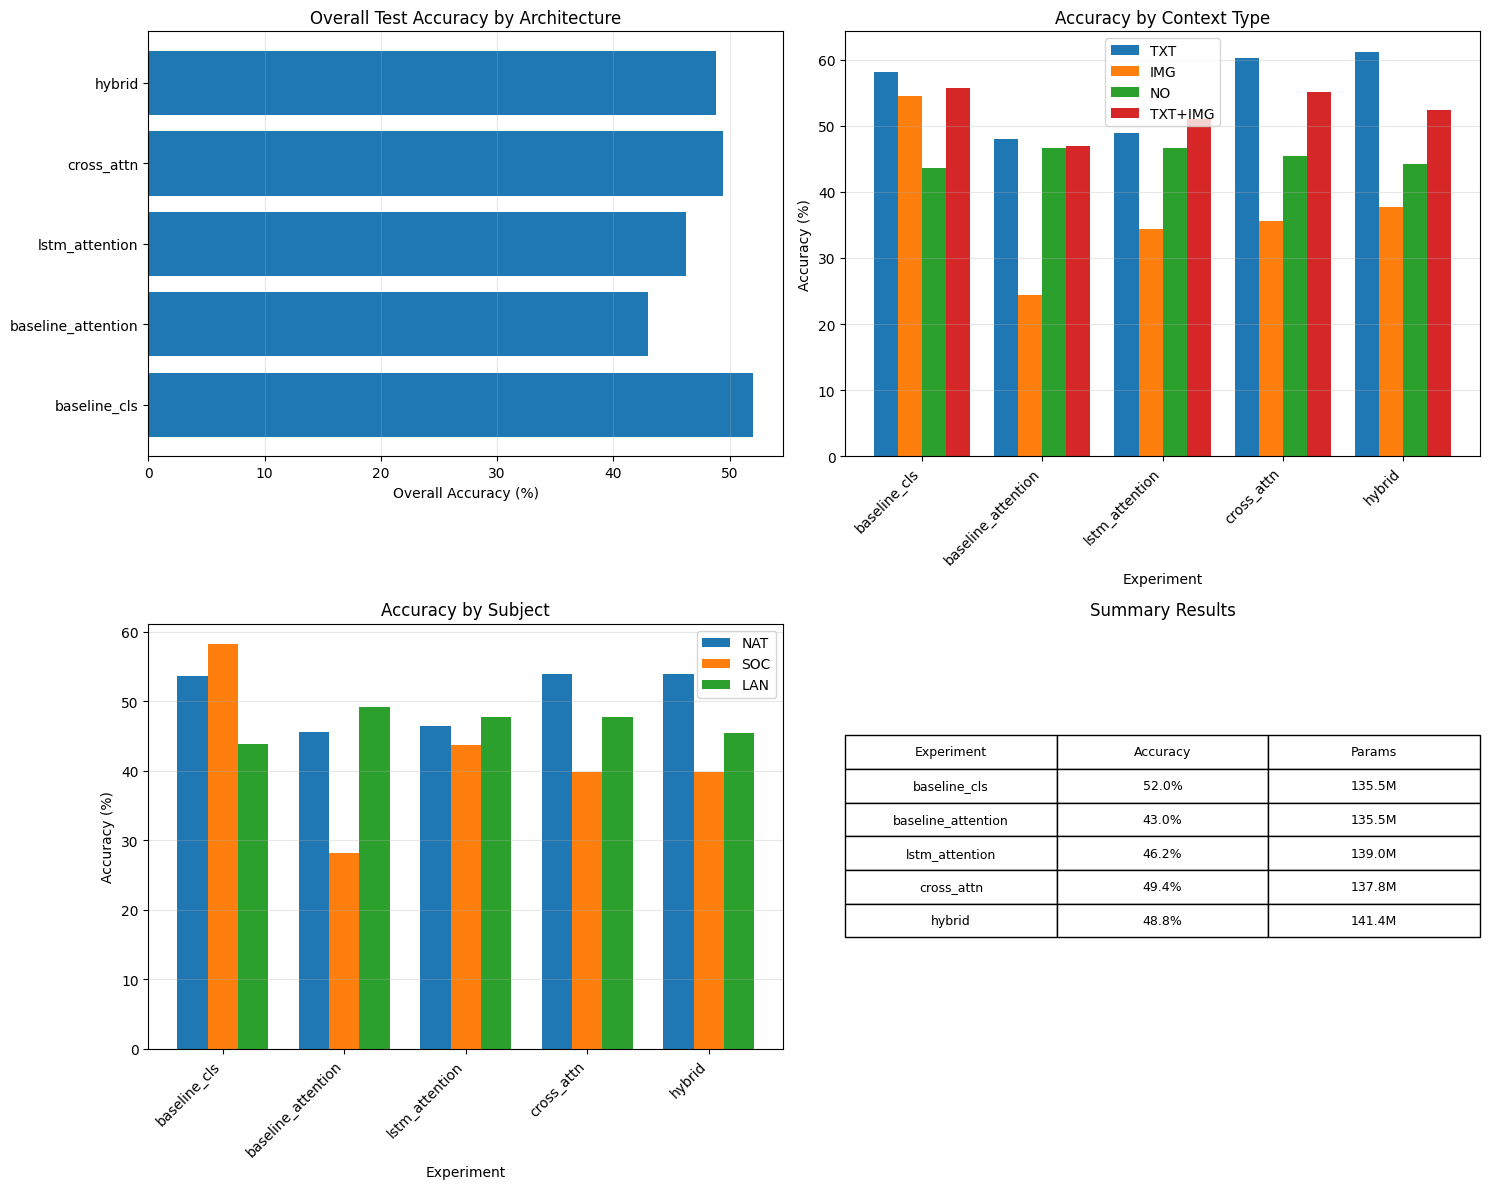

In [ ]:
# ==================== PLOT RESULTS ====================
if len(runner.results) > 1:
    runner.plot_comparison()

# ==================== VIEW RESULTS ====================
print("\n" + "="*60)
print("ALL EXPERIMENTS SUMMARY")
print("="*60)
for r in runner.results:
    print(f"\n{r['experiment_name']}:")
    print(f"  Overall: {r['test_breakdown']['Overall']:.2f}%")
    print(f"  NAT: {r['test_breakdown'].get('NAT', 0):.2f}%")
    print(f"  IMG: {r['test_breakdown'].get('IMG', 0):.2f}%")

# Check saved files
print("\n📁 Results saved to:")
print("  - experiments/results.json")
print("  - experiments/results.csv")
print("  - experiments/comparison.png")

In [ ]:
runner.results

[{'experiment_name': 'baseline_cls',
  'config': {'pooling_strategy': 'cls',
   'use_lstm': False,
   'use_cross_attention': False},
  'total_params': 135484997,
  'trainable_params': 135484997,
  'best_val_acc': np.float64(0.582),
  'test_acc': np.float64(0.52),
  'test_breakdown': {'Overall': np.float64(52.0),
   'Valid_predictions': np.float64(100.0),
   'NAT': np.float64(53.58490566037736),
   'SOC': np.float64(58.252427184466015),
   'LAN': np.float64(43.93939393939394),
   'TXT': np.float64(58.16326530612245),
   'IMG': np.float64(54.44444444444444),
   'NO': np.float64(43.63636363636363),
   'TXT+IMG': np.float64(55.78231292517006),
   'G1-6': np.float64(53.58255451713395),
   'G7-12': np.float64(49.162011173184354)},
  'training_time_seconds': 1541.544911},
 {'experiment_name': 'baseline_attention',
  'config': {'pooling_strategy': 'attention',
   'use_lstm': False,
   'use_cross_attention': False},
  'total_params': 135485766,
  'trainable_params': 135485766,
  'best_val_acc':

In [ ]:
"""

[{'experiment_name': 'baseline_cls',
  'config': {'pooling_strategy': 'cls',
   'use_lstm': False,
   'use_cross_attention': False},
  'total_params': 135484997,
  'trainable_params': 135484997,
  'best_val_acc': np.float64(0.582),
  'test_acc': np.float64(0.52),
  'test_breakdown': {'Overall': np.float64(52.0),
   'Valid_predictions': np.float64(100.0),
   'NAT': np.float64(53.58490566037736),
   'SOC': np.float64(58.252427184466015),
   'LAN': np.float64(43.93939393939394),
   'TXT': np.float64(58.16326530612245),
   'IMG': np.float64(54.44444444444444),
   'NO': np.float64(43.63636363636363),
   'TXT+IMG': np.float64(55.78231292517006),
   'G1-6': np.float64(53.58255451713395),
   'G7-12': np.float64(49.162011173184354)},
  'training_time_seconds': 1541.544911},
 {'experiment_name': 'baseline_attention',
  'config': {'pooling_strategy': 'attention',
   'use_lstm': False,
   'use_cross_attention': False},
  'total_params': 135485766,
  'trainable_params': 135485766,
  'best_val_acc': np.float64(0.48),
  'test_acc': np.float64(0.43),
  'test_breakdown': {'Overall': np.float64(43.0),
   'Valid_predictions': np.float64(100.0),
   'NAT': np.float64(45.660377358490564),
   'SOC': np.float64(28.155339805825243),
   'LAN': np.float64(49.24242424242424),
   'TXT': np.float64(47.95918367346938),
   'IMG': np.float64(24.444444444444443),
   'NO': np.float64(46.666666666666664),
   'TXT+IMG': np.float64(46.93877551020408),
   'G1-6': np.float64(42.679127725856695),
   'G7-12': np.float64(43.575418994413404)},
  'training_time_seconds': 1539.535976},
 {'experiment_name': 'lstm_attention',
  'config': {'pooling_strategy': 'attention',
   'use_lstm': True,
   'use_cross_attention': False},
  'total_params': 139033926,
  'trainable_params': 139033926,
  'best_val_acc': np.float64(0.504),
  'test_acc': np.float64(0.462),
  'test_breakdown': {'Overall': np.float64(46.2),
   'Valid_predictions': np.float64(100.0),
   'NAT': np.float64(46.41509433962264),
   'SOC': np.float64(43.689320388349515),
   'LAN': np.float64(47.72727272727273),
   'TXT': np.float64(48.97959183673469),
   'IMG': np.float64(34.44444444444444),
   'NO': np.float64(46.666666666666664),
   'TXT+IMG': np.float64(51.02040816326531),
   'G1-6': np.float64(47.97507788161994),
   'G7-12': np.float64(43.01675977653631)},
  'training_time_seconds': 1669.320914},
 {'experiment_name': 'cross_attn',
  'config': {'pooling_strategy': 'attention',
   'use_lstm': False,
   'use_cross_attention': True},
  'total_params': 137849670,
  'trainable_params': 137849670,
  'best_val_acc': np.float64(0.462),
  'test_acc': np.float64(0.494),
  'test_breakdown': {'Overall': np.float64(49.4),
   'Valid_predictions': np.float64(100.0),
   'NAT': np.float64(53.9622641509434),
   'SOC': np.float64(39.80582524271845),
   'LAN': np.float64(47.72727272727273),
   'TXT': np.float64(60.204081632653065),
   'IMG': np.float64(35.55555555555556),
   'NO': np.float64(45.45454545454545),
   'TXT+IMG': np.float64(55.10204081632652),
   'G1-6': np.float64(52.024922118380054),
   'G7-12': np.float64(44.6927374301676)},
  'training_time_seconds': 1556.578116},
 {'experiment_name': 'hybrid',
  'config': {'pooling_strategy': 'attention',
   'use_lstm': True,
   'use_cross_attention': True},
  'total_params': 141397830,
  'trainable_params': 141397830,
  'best_val_acc': np.float64(0.504),
  'test_acc': np.float64(0.488),
  'test_breakdown': {'Overall': np.float64(48.8),
   'Valid_predictions': np.float64(100.0),
   'NAT': np.float64(53.9622641509434),
   'SOC': np.float64(39.80582524271845),
   'LAN': np.float64(45.45454545454545),
   'TXT': np.float64(61.224489795918366),
   'IMG': np.float64(37.77777777777778),
   'NO': np.float64(44.24242424242424),
   'TXT+IMG': np.float64(52.38095238095239),
   'G1-6': np.float64(52.336448598130836),
   'G7-12': np.float64(42.45810055865922)},
  'training_time_seconds': 1689.775975}]

  """

Total results: 5
After filtering: 4
Experiments to plot: ['baseline_attention', 'lstm_attention', 'cross_attn', 'hybrid']

📊 Comparison plot saved to comparison_no_baseline_cls.png


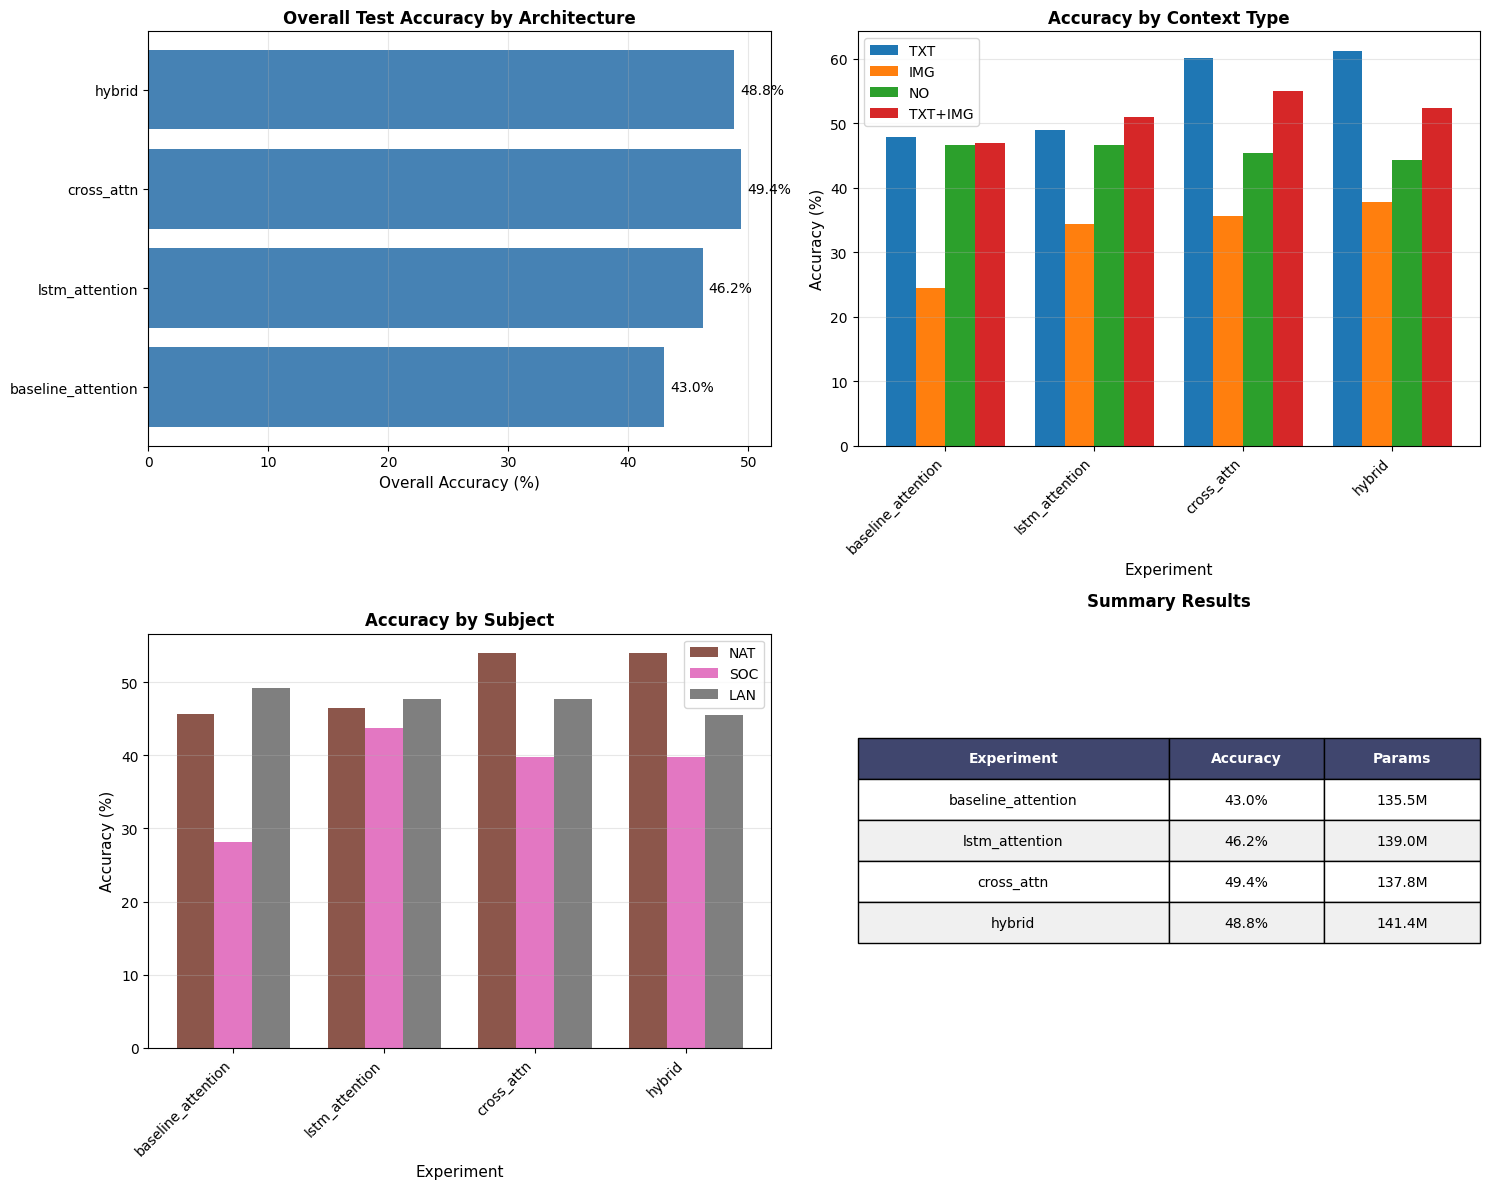

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Your results data
results = [{'experiment_name': 'baseline_cls',
  'config': {'pooling_strategy': 'cls',
   'use_lstm': False,
   'use_cross_attention': False},
  'total_params': 135484997,
  'trainable_params': 135484997,
  'best_val_acc': np.float64(0.582),
  'test_acc': np.float64(0.52),
  'test_breakdown': {'Overall': np.float64(52.0),
   'Valid_predictions': np.float64(100.0),
   'NAT': np.float64(53.58490566037736),
   'SOC': np.float64(58.252427184466015),
   'LAN': np.float64(43.93939393939394),
   'TXT': np.float64(58.16326530612245),
   'IMG': np.float64(54.44444444444444),
   'NO': np.float64(43.63636363636363),
   'TXT+IMG': np.float64(55.78231292517006),
   'G1-6': np.float64(53.58255451713395),
   'G7-12': np.float64(49.162011173184354)},
  'training_time_seconds': 1541.544911},
 {'experiment_name': 'baseline_attention',
  'config': {'pooling_strategy': 'attention',
   'use_lstm': False,
   'use_cross_attention': False},
  'total_params': 135485766,
  'trainable_params': 135485766,
  'best_val_acc': np.float64(0.48),
  'test_acc': np.float64(0.43),
  'test_breakdown': {'Overall': np.float64(43.0),
   'Valid_predictions': np.float64(100.0),
   'NAT': np.float64(45.660377358490564),
   'SOC': np.float64(28.155339805825243),
   'LAN': np.float64(49.24242424242424),
   'TXT': np.float64(47.95918367346938),
   'IMG': np.float64(24.444444444444443),
   'NO': np.float64(46.666666666666664),
   'TXT+IMG': np.float64(46.93877551020408),
   'G1-6': np.float64(42.679127725856695),
   'G7-12': np.float64(43.575418994413404)},
  'training_time_seconds': 1539.535976},
 {'experiment_name': 'lstm_attention',
  'config': {'pooling_strategy': 'attention',
   'use_lstm': True,
   'use_cross_attention': False},
  'total_params': 139033926,
  'trainable_params': 139033926,
  'best_val_acc': np.float64(0.504),
  'test_acc': np.float64(0.462),
  'test_breakdown': {'Overall': np.float64(46.2),
   'Valid_predictions': np.float64(100.0),
   'NAT': np.float64(46.41509433962264),
   'SOC': np.float64(43.689320388349515),
   'LAN': np.float64(47.72727272727273),
   'TXT': np.float64(48.97959183673469),
   'IMG': np.float64(34.44444444444444),
   'NO': np.float64(46.666666666666664),
   'TXT+IMG': np.float64(51.02040816326531),
   'G1-6': np.float64(47.97507788161994),
   'G7-12': np.float64(43.01675977653631)},
  'training_time_seconds': 1669.320914},
 {'experiment_name': 'cross_attn',
  'config': {'pooling_strategy': 'attention',
   'use_lstm': False,
   'use_cross_attention': True},
  'total_params': 137849670,
  'trainable_params': 137849670,
  'best_val_acc': np.float64(0.462),
  'test_acc': np.float64(0.494),
  'test_breakdown': {'Overall': np.float64(49.4),
   'Valid_predictions': np.float64(100.0),
   'NAT': np.float64(53.9622641509434),
   'SOC': np.float64(39.80582524271845),
   'LAN': np.float64(47.72727272727273),
   'TXT': np.float64(60.204081632653065),
   'IMG': np.float64(35.55555555555556),
   'NO': np.float64(45.45454545454545),
   'TXT+IMG': np.float64(55.10204081632652),
   'G1-6': np.float64(52.024922118380054),
   'G7-12': np.float64(44.6927374301676)},
  'training_time_seconds': 1556.578116},
 {'experiment_name': 'hybrid',
  'config': {'pooling_strategy': 'attention',
   'use_lstm': True,
   'use_cross_attention': True},
  'total_params': 141397830,
  'trainable_params': 141397830,
  'best_val_acc': np.float64(0.504),
  'test_acc': np.float64(0.488),
  'test_breakdown': {'Overall': np.float64(48.8),
   'Valid_predictions': np.float64(100.0),
   'NAT': np.float64(53.9622641509434),
   'SOC': np.float64(39.80582524271845),
   'LAN': np.float64(45.45454545454545),
   'TXT': np.float64(61.224489795918366),
   'IMG': np.float64(37.77777777777778),
   'NO': np.float64(44.24242424242424),
   'TXT+IMG': np.float64(52.38095238095239),
   'G1-6': np.float64(52.336448598130836),
   'G7-12': np.float64(42.45810055865922)},
  'training_time_seconds': 1689.775975}]

# Filter out baseline_cls
filtered_results = [r for r in results if r['experiment_name'] != 'baseline_cls']

print(f"Total results: {len(results)}")
print(f"After filtering: {len(filtered_results)}")
print(f"Experiments to plot: {[r['experiment_name'] for r in filtered_results]}")

# Create comparison plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Overall accuracy
ax1 = axes[0, 0]
exp_names = [r['experiment_name'] for r in filtered_results]
overall_accs = [r['test_breakdown']['Overall'] for r in filtered_results]
ax1.barh(exp_names, overall_accs, color='steelblue')
ax1.set_xlabel('Overall Accuracy (%)', fontsize=11)
ax1.set_title('Overall Test Accuracy by Architecture', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
for i, v in enumerate(overall_accs):
    ax1.text(v + 0.5, i, f'{v:.1f}%', va='center')

# 2. Context type comparison
ax2 = axes[0, 1]
contexts = ['TXT', 'IMG', 'NO', 'TXT+IMG']
x = np.arange(len(filtered_results))
width = 0.2
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
for i, ctx in enumerate(contexts):
    accs = [r['test_breakdown'].get(ctx, 0) for r in filtered_results]
    ax2.bar(x + i*width, accs, width, label=ctx, color=colors[i])
ax2.set_xlabel('Experiment', fontsize=11)
ax2.set_ylabel('Accuracy (%)', fontsize=11)
ax2.set_title('Accuracy by Context Type', fontsize=12, fontweight='bold')
ax2.set_xticks(x + width * 1.5)
ax2.set_xticklabels([r['experiment_name'] for r in filtered_results], rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Subject comparison
ax3 = axes[1, 0]
subjects = ['NAT', 'SOC', 'LAN']
x = np.arange(len(filtered_results))
width = 0.25
colors = ['#8c564b', '#e377c2', '#7f7f7f']
for i, subj in enumerate(subjects):
    accs = [r['test_breakdown'].get(subj, 0) for r in filtered_results]
    ax3.bar(x + i*width, accs, width, label=subj, color=colors[i])
ax3.set_xlabel('Experiment', fontsize=11)
ax3.set_ylabel('Accuracy (%)', fontsize=11)
ax3.set_title('Accuracy by Subject', fontsize=12, fontweight='bold')
ax3.set_xticks(x + width)
ax3.set_xticklabels([r['experiment_name'] for r in filtered_results], rotation=45, ha='right')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Summary table
ax4 = axes[1, 1]
ax4.axis('off')
table_data = [[r['experiment_name'],
              f"{r['test_breakdown']['Overall']:.1f}%",
              f"{r['trainable_params']/1e6:.1f}M"]
             for r in filtered_results]
table = ax4.table(cellText=table_data,
                 colLabels=['Experiment', 'Accuracy', 'Params'],
                 cellLoc='center',
                 loc='center',
                 colWidths=[0.5, 0.25, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Style the header
for i in range(3):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, len(filtered_results) + 1):
    for j in range(3):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f0f0f0')

ax4.set_title('Summary Results', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('comparison_no_baseline_cls.png', dpi=300, bbox_inches='tight')
print(f"\n📊 Comparison plot saved to comparison_no_baseline_cls.png")
plt.show()

In [ ]:
"""Seperated graphs"""

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Your results data
results = [{'experiment_name': 'baseline_cls',
  'config': {'pooling_strategy': 'cls',
   'use_lstm': False,
   'use_cross_attention': False},
  'total_params': 135484997,
  'trainable_params': 135484997,
  'best_val_acc': np.float64(0.582),
  'test_acc': np.float64(0.52),
  'test_breakdown': {'Overall': np.float64(52.0),
   'Valid_predictions': np.float64(100.0),
   'NAT': np.float64(53.58490566037736),
   'SOC': np.float64(58.252427184466015),
   'LAN': np.float64(43.93939393939394),
   'TXT': np.float64(58.16326530612245),
   'IMG': np.float64(54.44444444444444),
   'NO': np.float64(43.63636363636363),
   'TXT+IMG': np.float64(55.78231292517006),
   'G1-6': np.float64(53.58255451713395),
   'G7-12': np.float64(49.162011173184354)},
  'training_time_seconds': 1541.544911},
 {'experiment_name': 'baseline_attention',
  'config': {'pooling_strategy': 'attention',
   'use_lstm': False,
   'use_cross_attention': False},
  'total_params': 135485766,
  'trainable_params': 135485766,
  'best_val_acc': np.float64(0.48),
  'test_acc': np.float64(0.43),
  'test_breakdown': {'Overall': np.float64(43.0),
   'Valid_predictions': np.float64(100.0),
   'NAT': np.float64(45.660377358490564),
   'SOC': np.float64(28.155339805825243),
   'LAN': np.float64(49.24242424242424),
   'TXT': np.float64(47.95918367346938),
   'IMG': np.float64(24.444444444444443),
   'NO': np.float64(46.666666666666664),
   'TXT+IMG': np.float64(46.93877551020408),
   'G1-6': np.float64(42.679127725856695),
   'G7-12': np.float64(43.575418994413404)},
  'training_time_seconds': 1539.535976},
 {'experiment_name': 'lstm_attention',
  'config': {'pooling_strategy': 'attention',
   'use_lstm': True,
   'use_cross_attention': False},
  'total_params': 139033926,
  'trainable_params': 139033926,
  'best_val_acc': np.float64(0.504),
  'test_acc': np.float64(0.462),
  'test_breakdown': {'Overall': np.float64(46.2),
   'Valid_predictions': np.float64(100.0),
   'NAT': np.float64(46.41509433962264),
   'SOC': np.float64(43.689320388349515),
   'LAN': np.float64(47.72727272727273),
   'TXT': np.float64(48.97959183673469),
   'IMG': np.float64(34.44444444444444),
   'NO': np.float64(46.666666666666664),
   'TXT+IMG': np.float64(51.02040816326531),
   'G1-6': np.float64(47.97507788161994),
   'G7-12': np.float64(43.01675977653631)},
  'training_time_seconds': 1669.320914},
 {'experiment_name': 'cross_attn',
  'config': {'pooling_strategy': 'attention',
   'use_lstm': False,
   'use_cross_attention': True},
  'total_params': 137849670,
  'trainable_params': 137849670,
  'best_val_acc': np.float64(0.462),
  'test_acc': np.float64(0.494),
  'test_breakdown': {'Overall': np.float64(49.4),
   'Valid_predictions': np.float64(100.0),
   'NAT': np.float64(53.9622641509434),
   'SOC': np.float64(39.80582524271845),
   'LAN': np.float64(47.72727272727273),
   'TXT': np.float64(60.204081632653065),
   'IMG': np.float64(35.55555555555556),
   'NO': np.float64(45.45454545454545),
   'TXT+IMG': np.float64(55.10204081632652),
   'G1-6': np.float64(52.024922118380054),
   'G7-12': np.float64(44.6927374301676)},
  'training_time_seconds': 1556.578116},
 {'experiment_name': 'hybrid',
  'config': {'pooling_strategy': 'attention',
   'use_lstm': True,
   'use_cross_attention': True},
  'total_params': 141397830,
  'trainable_params': 141397830,
  'best_val_acc': np.float64(0.504),
  'test_acc': np.float64(0.488),
  'test_breakdown': {'Overall': np.float64(48.8),
   'Valid_predictions': np.float64(100.0),
   'NAT': np.float64(53.9622641509434),
   'SOC': np.float64(39.80582524271845),
   'LAN': np.float64(45.45454545454545),
   'TXT': np.float64(61.224489795918366),
   'IMG': np.float64(37.77777777777778),
   'NO': np.float64(44.24242424242424),
   'TXT+IMG': np.float64(52.38095238095239),
   'G1-6': np.float64(52.336448598130836),
   'G7-12': np.float64(42.45810055865922)},
  'training_time_seconds': 1689.775975}]

# Filter out baseline_cls
filtered_results = [r for r in results if r['experiment_name'] != 'baseline_cls']

print(f"Total results: {len(results)}")
print(f"After filtering: {len(filtered_results)}")
print(f"Experiments to plot: {[r['experiment_name'] for r in filtered_results]}")

# ============================================================
# PLOT 1: Overall Accuracy
# ============================================================
fig1, ax1 = plt.subplots(figsize=(10, 6))
exp_names = [r['experiment_name'] for r in filtered_results]
overall_accs = [r['test_breakdown']['Overall'] for r in filtered_results]
bars = ax1.barh(exp_names, overall_accs, color='steelblue')
ax1.set_xlabel('Overall Accuracy (%)', fontsize=12)
ax1.set_title('Overall Test Accuracy by Architecture', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
for i, v in enumerate(overall_accs):
    ax1.text(v + 0.5, i, f'{v:.1f}%', va='center', fontsize=10)
plt.tight_layout()
plt.savefig('1_overall_accuracy.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 1_overall_accuracy.png")
plt.close()

# ============================================================
# PLOT 2: Context Type Comparison
# ============================================================
fig2, ax2 = plt.subplots(figsize=(12, 6))
contexts = ['TXT', 'IMG', 'NO', 'TXT+IMG']
x = np.arange(len(filtered_results))
width = 0.2
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
for i, ctx in enumerate(contexts):
    accs = [r['test_breakdown'].get(ctx, 0) for r in filtered_results]
    ax2.bar(x + i*width, accs, width, label=ctx, color=colors[i])
ax2.set_xlabel('Experiment', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Accuracy by Context Type', fontsize=14, fontweight='bold')
ax2.set_xticks(x + width * 1.5)
ax2.set_xticklabels([r['experiment_name'] for r in filtered_results], rotation=45, ha='right')
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('2_context_type.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 2_context_type.png")
plt.close()

# ============================================================
# PLOT 3: Subject Comparison
# ============================================================
fig3, ax3 = plt.subplots(figsize=(12, 6))
subjects = ['NAT', 'SOC', 'LAN']
x = np.arange(len(filtered_results))
width = 0.25
colors = ['#8c564b', '#e377c2', '#7f7f7f']
for i, subj in enumerate(subjects):
    accs = [r['test_breakdown'].get(subj, 0) for r in filtered_results]
    ax3.bar(x + i*width, accs, width, label=subj, color=colors[i])
ax3.set_xlabel('Experiment', fontsize=12)
ax3.set_ylabel('Accuracy (%)', fontsize=12)
ax3.set_title('Accuracy by Subject', fontsize=14, fontweight='bold')
ax3.set_xticks(x + width)
ax3.set_xticklabels([r['experiment_name'] for r in filtered_results], rotation=45, ha='right')
ax3.legend(fontsize=10)
ax3.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('3_subject_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 3_subject_comparison.png")
plt.close()

# ============================================================
# PLOT 4: Summary Table
# ============================================================
fig4, ax4 = plt.subplots(figsize=(10, 6))
ax4.axis('off')
table_data = [[r['experiment_name'],
              f"{r['test_breakdown']['Overall']:.1f}%",
              f"{r['trainable_params']/1e6:.1f}M",
              f"{r['training_time_seconds']:.0f}s"]
             for r in filtered_results]
table = ax4.table(cellText=table_data,
                 colLabels=['Experiment', 'Accuracy', 'Params', 'Time'],
                 cellLoc='center',
                 loc='center',
                 colWidths=[0.4, 0.2, 0.2, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 3)

# Style the header
for i in range(4):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, len(filtered_results) + 1):
    for j in range(4):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f0f0f0')

ax4.set_title('Summary Results', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('4_summary_table.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 4_summary_table.png")
plt.close()

print("\n📊 All plots saved successfully!")

Total results: 5
After filtering: 4
Experiments to plot: ['baseline_attention', 'lstm_attention', 'cross_attn', 'hybrid']
✓ Saved: 1_overall_accuracy.png
✓ Saved: 2_context_type.png
✓ Saved: 3_subject_comparison.png
✓ Saved: 4_summary_table.png

📊 All plots saved successfully!


In [ ]:
"""The below code is not to be run"""

'The below code is not to be run'

In [ ]:
# # ==================== DETAILED EVALUATION WITH BREAKDOWN ====================
# # Add this to your code to get the same metrics as your original file

# def evaluate_detailed(model, dataloader, device):
#     """
#     Evaluate model with detailed breakdown by:
#     - Subject (NAT, SOC, LAN)
#     - Context type (TXT, IMG, NO, TXT+IMG)
#     - Grade level (G1-6, G7-12)
#     """
#     model.eval()
#     total_loss = 0

#     # Storage for predictions and metadata
#     all_preds = []
#     all_labels = []
#     all_subjects = []
#     all_has_image = []
#     all_has_text = []
#     all_grades = []

#     with torch.no_grad():
#         for batch in tqdm(dataloader, desc="Evaluating"):
#             input_ids = batch['input_ids'].to(device)
#             attention_mask = batch['attention_mask'].to(device)
#             images = batch['image'].to(device)
#             has_image = batch['has_image'].to(device)
#             labels = batch['label'].to(device)

#             logits = model(input_ids, attention_mask, images, has_image)
#             loss = F.cross_entropy(logits, labels)
#             total_loss += loss.item()

#             preds = torch.argmax(logits, dim=1)

#             # Store predictions and metadata
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())
#             all_subjects.extend(batch['subject'])
#             all_has_image.extend(has_image.cpu().numpy())
#             all_grades.extend(batch['grade'])

#             # Check if sample has text context (hint)
#             # You'll need to add this to your dataset
#             if 'has_text' in batch:
#                 all_has_text.extend(batch['has_text'].cpu().numpy())

#     # Convert to numpy
#     all_preds = np.array(all_preds)
#     all_labels = np.array(all_labels)
#     all_has_image = np.array(all_has_image)
#     all_grades = np.array(all_grades)

#     # Compute breakdown
#     results = {}

#     # Overall accuracy
#     correct_mask = all_preds == all_labels
#     results['Overall'] = np.mean(correct_mask) * 100
#     results['Valid_predictions'] = 100.0  # All predictions are valid now

#     # By Subject
#     for subject_code, subject_name in [('natural science', 'NAT'),
#                                         ('social science', 'SOC'),
#                                         ('language science', 'LAN')]:
#         mask = np.array([s.lower() == subject_code for s in all_subjects])
#         if mask.sum() > 0:
#             results[subject_name] = np.mean(correct_mask[mask]) * 100

#     # By Context Type
#     has_image_bool = all_has_image.astype(bool)

#     # If you have has_text in your dataset:
#     if len(all_has_text) > 0:
#         all_has_text = np.array(all_has_text)
#         has_text_bool = all_has_text.astype(bool)

#         # Text only
#         txt_only_mask = has_text_bool & ~has_image_bool
#         if txt_only_mask.sum() > 0:
#             results['TXT'] = np.mean(correct_mask[txt_only_mask]) * 100

#         # Image only
#         img_only_mask = has_image_bool & ~has_text_bool
#         if img_only_mask.sum() > 0:
#             results['IMG'] = np.mean(correct_mask[img_only_mask]) * 100

#         # No context
#         no_context_mask = ~has_text_bool & ~has_image_bool
#         if no_context_mask.sum() > 0:
#             results['NO'] = np.mean(correct_mask[no_context_mask]) * 100

#         # Text + Image
#         both_mask = has_text_bool & has_image_bool
#         if both_mask.sum() > 0:
#             results['TXT+IMG'] = np.mean(correct_mask[both_mask]) * 100
#     else:
#         # Simplified: just with/without image
#         with_img_mask = has_image_bool
#         without_img_mask = ~has_image_bool

#         if with_img_mask.sum() > 0:
#             results['IMG'] = np.mean(correct_mask[with_img_mask]) * 100
#         if without_img_mask.sum() > 0:
#             results['NO'] = np.mean(correct_mask[without_img_mask]) * 100

#     # By Grade Level
#     # Convert grade strings to groups
#     elementary_mask = np.array([g in ['grade1', 'grade2', 'grade3', 'grade4', 'grade5', 'grade6']
#                                for g in all_grades])
#     secondary_mask = np.array([g in ['grade7', 'grade8', 'grade9', 'grade10', 'grade11', 'grade12']
#                               for g in all_grades])

#     if elementary_mask.sum() > 0:
#         results['G1-6'] = np.mean(correct_mask[elementary_mask]) * 100
#     if secondary_mask.sum() > 0:
#         results['G7-12'] = np.mean(correct_mask[secondary_mask]) * 100

#     avg_loss = total_loss / len(dataloader)
#     accuracy = results['Overall'] / 100

#     return avg_loss, accuracy, results, all_preds, all_labels


# # ==================== UPDATE YOUR DATASET CLASS ====================
# # Add this method to ScienceQADataset to track if sample has text context

# class ScienceQADataset(Dataset):
#     """Dataset for ScienceQA with proper preprocessing"""

#     def __init__(self, dataset, tokenizer, transform, max_length=256):
#         self.dataset = dataset
#         self.tokenizer = tokenizer
#         self.transform = transform
#         self.max_length = max_length

#     def __len__(self):
#         return len(self.dataset)

#     def _format_question(self, example):
#         """Format question with choices and hint"""
#         question = example['question']
#         choices = example['choices']
#         hint = example.get('hint', '')

#         # Format choices
#         choices_text = "\n".join([
#             f"{chr(65+i)}) {choice}"
#             for i, choice in enumerate(choices)
#         ])

#         # Build full text
#         if hint and hint.strip():
#             text = f"Context: {hint}\n\nQuestion: {question}\n\nChoices:\n{choices_text}"
#         else:
#             text = f"Question: {question}\n\nChoices:\n{choices_text}"

#         return text, bool(hint and hint.strip())  # Return if has text context

#     def __getitem__(self, idx):
#         example = self.dataset[idx]

#         # Format text and check if has context
#         text, has_text = self._format_question(example)

#         # Tokenize
#         encoding = self.tokenizer(
#             text,
#             max_length=self.max_length,
#             padding='max_length',
#             truncation=True,
#             return_tensors='pt'
#         )

#         # Process image
#         has_image = example['image'] is not None
#         if has_image:
#             image = example['image']
#             if not isinstance(image, Image.Image):
#                 image = Image.fromarray(np.array(image))
#             if image.mode != 'RGB':
#                 image = image.convert('RGB')
#             image_tensor = self.transform(image)
#         else:
#             # Dummy image (will be masked out)
#             image_tensor = torch.zeros(3, 224, 224)

#         return {
#             'input_ids': encoding['input_ids'].squeeze(0),
#             'attention_mask': encoding['attention_mask'].squeeze(0),
#             'image': image_tensor,
#             'has_image': torch.tensor(has_image, dtype=torch.bool),
#             'has_text': torch.tensor(has_text, dtype=torch.bool),  # NEW
#             'label': torch.tensor(example['answer'], dtype=torch.long),
#             'subject': example.get('subject', 'UNK'),
#             'grade': example.get('grade', 'UNK')
#         }


# # ==================== UPDATE EXPERIMENT RUNNER ====================
# # Replace the evaluate call in run_experiment

# class ExperimentRunner:
#     """Manages multiple experiments and tracks results"""

#     def __init__(self, output_dir="experiments"):
#         self.output_dir = Path(output_dir)
#         self.output_dir.mkdir(exist_ok=True)
#         self.results = []

#     def run_experiment(
#         self,
#         experiment_name,
#         model_config,
#         train_loader,
#         val_loader,
#         test_loader,
#         num_epochs=3,
#         learning_rate=2e-5,
#         device='cuda'
#     ):
#         """Run single experiment"""
#         print(f"\n{'='*60}")
#         print(f"EXPERIMENT: {experiment_name}")
#         print(f"{'='*60}")
#         print(f"Config: {model_config}")

#         # Initialize model
#         model = MultimodalQA(**model_config).to(device)

#         # Count parameters
#         total_params = sum(p.numel() for p in model.parameters())
#         trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
#         print(f"Total parameters: {total_params:,}")
#         print(f"Trainable parameters: {trainable_params:,}")

#         # Optimizer and scheduler
#         optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#         total_steps = len(train_loader) * num_epochs
#         scheduler = get_linear_schedule_with_warmup(
#             optimizer,
#             num_warmup_steps=500,
#             num_training_steps=total_steps
#         )

#         # Training loop
#         best_val_acc = 0
#         start_time = datetime.now()

#         for epoch in range(num_epochs):
#             print(f"\nEpoch {epoch+1}/{num_epochs}")

#             train_loss, train_acc = train_epoch(
#                 model, train_loader, optimizer, scheduler, device
#             )

#             # Use detailed evaluation
#             val_loss, val_acc, val_breakdown, _, _ = evaluate_detailed(
#                 model, val_loader, device
#             )

#             print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
#             print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
#             print(f"Val Overall: {val_breakdown['Overall']:.2f}%")

#             if val_acc > best_val_acc:
#                 best_val_acc = val_acc
#                 torch.save(
#                     model.state_dict(),
#                     self.output_dir / f"{experiment_name}_best.pt"
#                 )

#         # Final evaluation on test set with detailed breakdown
#         print("\nEvaluating on test set...")
#         test_loss, test_acc, test_breakdown, test_preds, test_labels = evaluate_detailed(
#             model, test_loader, device
#         )

#         training_time = (datetime.now() - start_time).total_seconds()

#         # Print detailed results
#         self.print_detailed_results(experiment_name, test_breakdown, test_preds, test_labels)

#         # Store results
#         result = {
#             'experiment_name': experiment_name,
#             'config': model_config,
#             'total_params': total_params,
#             'trainable_params': trainable_params,
#             'best_val_acc': best_val_acc,
#             'test_acc': test_acc,
#             'test_breakdown': test_breakdown,
#             'training_time_seconds': training_time
#         }
#         self.results.append(result)

#         # Save results
#         self.save_results()

#         return result

#     def print_detailed_results(self, experiment_name, results, preds, labels):
#         """Print detailed results like your original file"""

#         print("\n" + "="*60)
#         print(f"📊 EVALUATION RESULTS - {experiment_name}")
#         print("="*60)

#         # Overall Performance
#         print("\n🎯 OVERALL PERFORMANCE:")
#         print("-" * 40)
#         print(f"Overall Accuracy:      {results['Overall']:.2f}%")
#         print(f"Valid Predictions:     {results['Valid_predictions']:.2f}%")
#         print(f"Failed Extractions:    {100 - results['Valid_predictions']:.2f}%")

#         # By Subject
#         print("\n📚 ACCURACY BY SUBJECT:")
#         print("-" * 40)
#         subject_results = {
#             'Natural Science': results.get('NAT', 0),
#             'Social Science': results.get('SOC', 0),
#             'Language Science': results.get('LAN', 0)
#         }
#         for subject, acc in subject_results.items():
#             if acc > 0:
#                 print(f"{subject:20s}: {acc:6.2f}%")

#         # By Context Type
#         print("\n🔍 ACCURACY BY CONTEXT TYPE:")
#         print("-" * 40)
#         context_results = {
#             'Text Only': results.get('TXT', 0),
#             'Image Only': results.get('IMG', 0),
#             'No Context': results.get('NO', 0),
#             'Text + Image': results.get('TXT+IMG', 0)
#         }
#         for context, acc in context_results.items():
#             if acc > 0:
#                 bar = '█' * int(acc / 2)
#                 print(f"{context:20s}: {acc:6.2f}% {bar}")

#         # By Grade Level
#         print("\n🎓 ACCURACY BY GRADE LEVEL:")
#         print("-" * 40)
#         grade_results = {
#             'Elementary (G1-6)': results.get('G1-6', 0),
#             'Secondary (G7-12)': results.get('G7-12', 0)
#         }
#         for grade, acc in grade_results.items():
#             if acc > 0:
#                 print(f"{grade:20s}: {acc:6.2f}%")

#         # Detailed Table
#         print("\n📋 DETAILED RESULTS TABLE:")
#         print("-" * 60)
#         results_data = []
#         for key, value in results.items():
#             if key not in ['Overall', 'Valid_predictions']:
#                 results_data.append({'Metric': key, 'Accuracy (%)': f"{value:.2f}"})

#         df_results = pd.DataFrame(results_data)
#         print(df_results.to_string(index=False))

#         # Confusion Analysis
#         print("\n🔬 PREDICTION ANALYSIS:")
#         print("-" * 40)
#         valid_mask = preds >= 0
#         total_predictions = len(preds)
#         correct_predictions = (preds[valid_mask] == labels[valid_mask]).sum()
#         wrong_predictions = (preds[valid_mask] != labels[valid_mask]).sum()
#         failed_predictions = (~valid_mask).sum()

#         print(f"Total Questions:       {total_predictions:5d}")
#         print(f"Correct Predictions:   {correct_predictions:5d} ({correct_predictions/total_predictions*100:5.2f}%)")
#         print(f"Wrong Predictions:     {wrong_predictions:5d} ({wrong_predictions/total_predictions*100:5.2f}%)")
#         print(f"Failed Extractions:    {failed_predictions:5d} ({failed_predictions/total_predictions*100:5.2f}%)")

#     def save_results(self):
#         """Save all results to JSON and CSV"""
#         # JSON for full details
#         with open(self.output_dir / 'results.json', 'w') as f:
#             json.dump(self.results, f, indent=2)

#         # CSV for easy comparison
#         df = pd.DataFrame([{
#             'experiment': r['experiment_name'],
#             'pooling': r['config'].get('pooling_strategy', 'N/A'),
#             'use_lstm': r['config'].get('use_lstm', False),
#             'use_cross_attn': r['config'].get('use_cross_attention', False),
#             'overall_acc': r['test_breakdown']['Overall'],
#             'with_image': r['test_breakdown'].get('IMG', 0),
#             'without_image': r['test_breakdown'].get('NO', 0),
#             'NAT': r['test_breakdown'].get('NAT', 0),
#             'SOC': r['test_breakdown'].get('SOC', 0),
#             'LAN': r['test_breakdown'].get('LAN', 0),
#             'G1-6': r['test_breakdown'].get('G1-6', 0),
#             'G7-12': r['test_breakdown'].get('G7-12', 0),
#             'params_M': r['trainable_params'] / 1e6,
#             'time_s': r['training_time_seconds']
#         } for r in self.results])

#         df.to_csv(self.output_dir / 'results.csv', index=False)
#         print(f"\n💾 Results saved to {self.output_dir}")

#     def plot_comparison(self):
#         """Create comparison visualizations"""
#         # ... (same as before)
#         pass